# Generating RASS visualisations using SkyView and the XGA image class

## Import Statements

In [1]:
from subprocess import Popen, PIPE
import pandas as pd
from astropy.units import Quantity
from astropy.cosmology import LambdaCDM
import numpy as np
import os
from shutil import move
from tqdm import tqdm

from xga.products import Image
from xga.imagetools.misc import physical_rad_to_pix

## Defining useful functions

Here a couple of functions are defined for functionality that is used multiple times in this notebook. The first uses the SkyView in a jar code (just downloaded from their website https://skyview.gsfc.nasa.gov/current/docs/jar.html, this is a super bodgy notebook) to generate ROSAT visualisation images for LoVoCCs clusters. I wouldn't ever make use of these for science analyses because I have no idea how they were made, but I'm in a rush.

The second function is a simple loop that uses the XGA Image class view method to create a useful ROSAT visualisation of each cluster, with a circle indicating the MCXC $R_{500}$, having been zoomed in from the original 1200 pixel images generated for each cluster.

In [8]:
def rass_im(name, ra, dec):
    # This ensures that the directory used to store the SkyView generated fits files exists
    if not os.path.exists('rass_ims/fits/'):
        os.makedirs('rass_ims/fits/')
    
    # SkyView writes to the filename output.fits, so I make sure that there aren't any left in the 
    #  current directory before I begin the generation process
    if os.path.exists('output.fits'):
        os.remove('output.fits')
    
    # Don't want the output.fits file to be called that forever, so I give it a more useful name
    #  based upon the passed name. 
    new_name = 'rass_ims/fits/{n}_rass_im.fits'.format(n=name)
    if not os.path.exists(new_name):
        # This is a really unsophisticated little interface function, so I just hardcode this essentially
        #  random choice
        pix = 1200
        # Setup the call to the SkyView jar, then run it using Popen
        cmd = 'java -jar skyview.jar position={r},{d} survey=RASS pixels={p}'.format(r=ra, d=dec, p=pix)
        out, err = Popen(cmd, shell=True, stdout=PIPE, stderr=PIPE).communicate()

        # Then I move the file to the new name
        move('output.fits', new_name)
    
    # Finally load the ROSAT fits image into an XGA Image instance (first time I've tried this
    #  and it worked perfectly, yay!)
    im = Image(new_name, '', 'ROSAT', '', '', '', Quantity(0.1, 'keV'), Quantity(2.4, 'keV'))
    return im


def view_subsamp(sub_samp):
    
    # This ensures that the directory used to store the XGA generated visualisations exists
    if not os.path.exists('rass_ims/xga_vis/'):
        os.makedirs('rass_ims/xga_vis/')
    
    # This function loops through a sub-sample of the LoVoCCs clusters and shows visualisations using
    #  ROSAT data. They are also saved, and include a white circle indicating the MCXC R500
    for row_ind, row in sub_samp.iterrows():
        # Fetch the relevant image from the dictionary using the cluster name
        rel_im = rel_ims[row['name']]
        
        rel_im.src_name = row['name']
        print(row['name'])
        
        # Setup an astropy quantity
        pos = Quantity(row[['ra', 'dec']], 'deg')
        r = Quantity(row['R500'], 'Mpc')
        # Use an XGA method to convert the R500 Mpc to a pixel radius for the current image
        r_pix = physical_rad_to_pix(rel_im, r, pos, row['redshift'], cosmo)
        # Double that radius to use for zooming in on the cluster
        exp_r_pix = r_pix*2

        # Convert the RA-Dec position to pixel position, for calculating zoom in X and Y limits
        pos_pix = rel_im.coord_conv(pos, 'pix')
        
        # Set up limits so that we zoom in on a box 4R500x4R500 
        xlims = ((pos_pix[0]-exp_r_pix).value, (pos_pix[0]+exp_r_pix).value)
        ylims = ((pos_pix[1]-exp_r_pix).value, (pos_pix[1]+exp_r_pix).value)
        
        # Show the visualisation, adding a crosshair centred on MCXC coords and with a white circle for 
        #  the R500 from MCXC
        rel_im.view(pos, manual_zoom_xlims=xlims, manual_zoom_ylims=ylims, 
                    radial_bins_pix=np.array([0, r_pix.value]), zoom_in=True)
        path = 'rass_ims/xga_vis/{n}.png'.format(n=row['name'])
        rel_im.save_view(path, pos, manual_zoom_xlims=xlims, manual_zoom_ylims=ylims, 
                         radial_bins_pix=np.array([0, r_pix.value]), zoom_in=True)

## Setting up cosmology

Using the same cosmology as in the LoVoCCs sample paper (https://iopscience.iop.org/article/10.3847/1538-4357/ac68e8#artAbst):

In [3]:
cosmo = LambdaCDM(71, 0.2648, 0.6904, 0.0448)

In [4]:
unobs_samp = pd.read_csv('unobserved_subsample.csv')
full_samp = pd.read_csv('lovoccs_southnorth.csv')
obs_samp = full_samp[~full_samp['name'].isin(unobs_samp['name'])]

print("There are", full_samp.shape[0], "LoVoCCs in total")
print("Of those", unobs_samp.shape[0], "require XMM observations")

There are 144 LoVoCCs in total
Of those 34 require XMM observations


## Generating ROSAT image FITS files

In [5]:
with tqdm(desc='Generating RASS Images', total=len(full_samp)) as onwards:
    rel_ims = {}
    for row_ind, row in full_samp.iterrows():
        im = rass_im(row['name'], row['ra'], row['dec'])
        rel_ims[row['name']] = im
        onwards.update(1)

Generating RASS Images: 100%|█████████████████████████████████████████████| 144/144 [00:00<00:00, 1673.58it/s]


## RASS images of the clusters _not_ observed by XMM

MCXCJ0028.6-2338


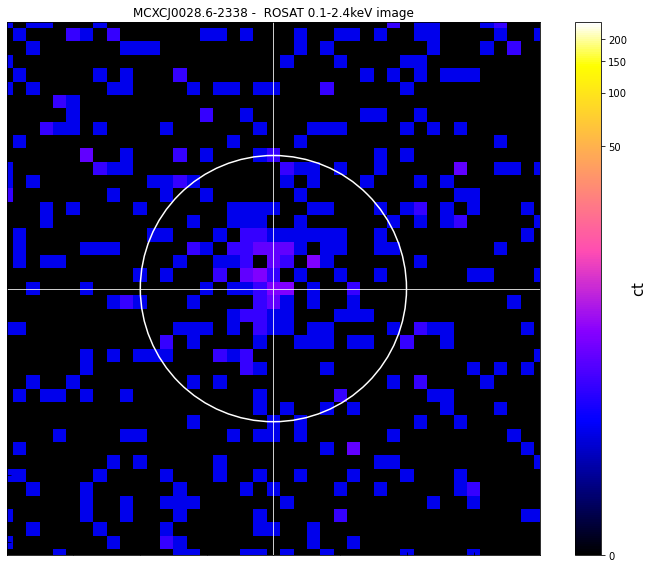

MCXCJ0041.7+2124


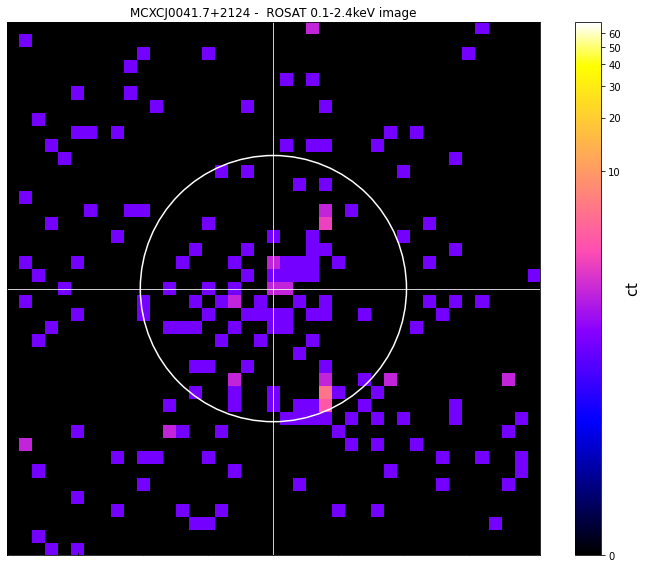

MCXCJ0043.8+2424


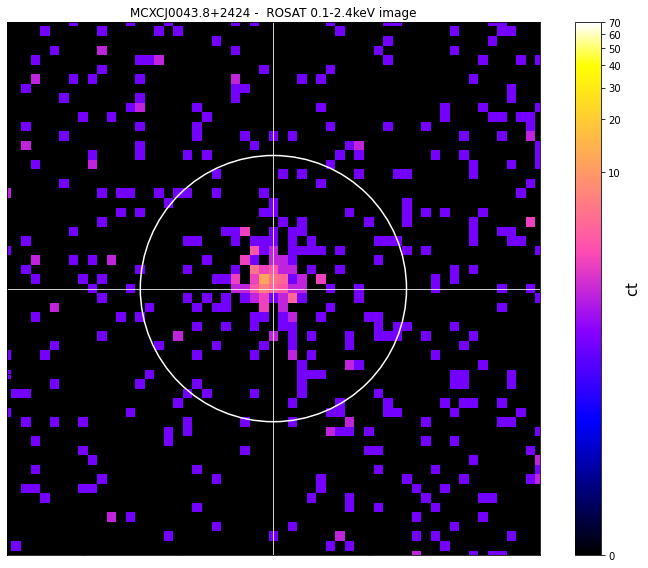

MCXCJ0049.8+2426


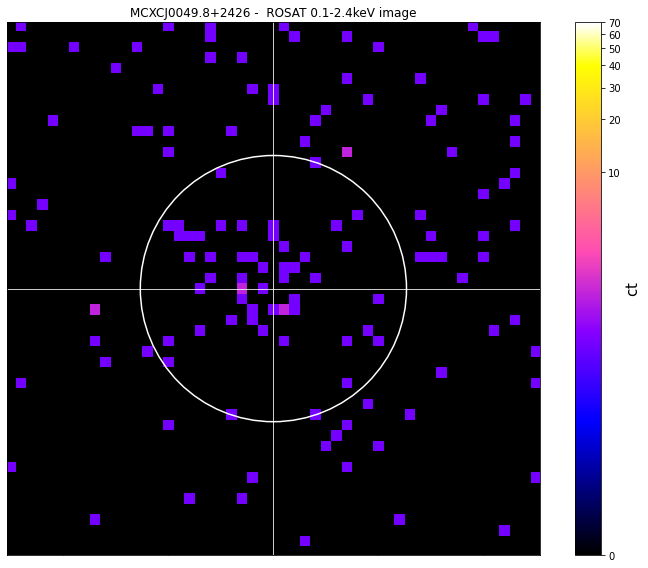

MCXCJ0052.7-8015


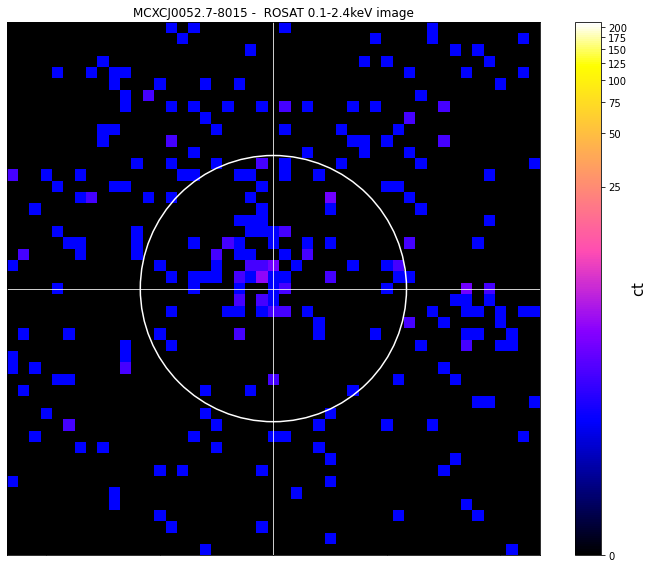

MCXCJ0107.8-3643


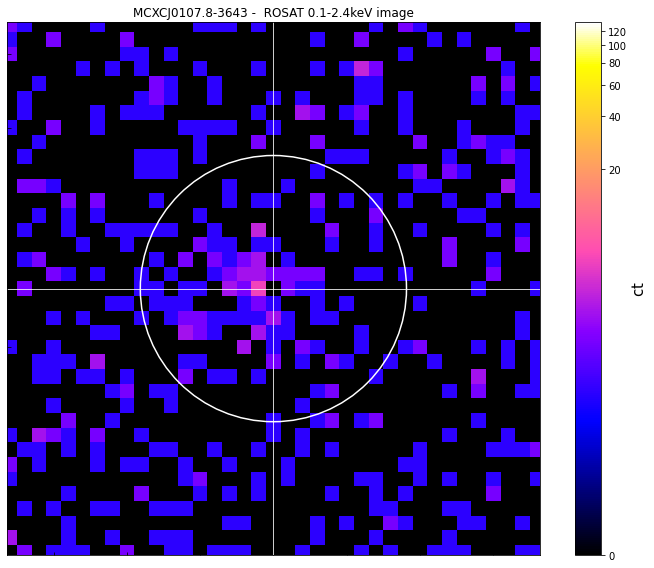

MCXCJ0212.8-4707


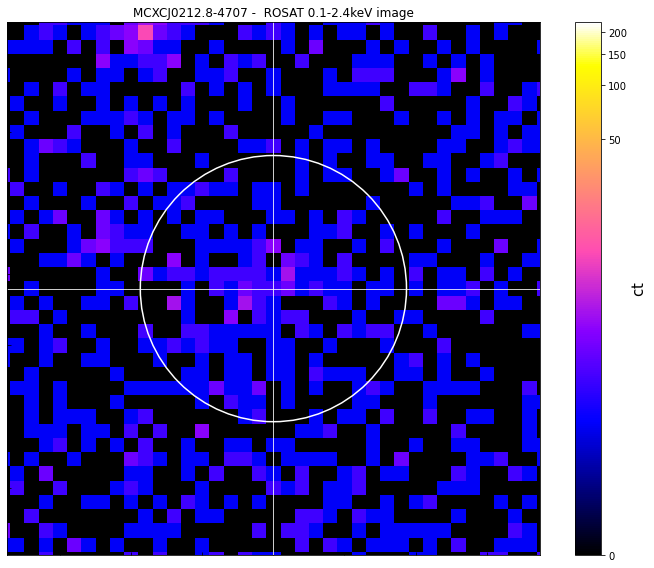

MCXCJ0704.4+6318


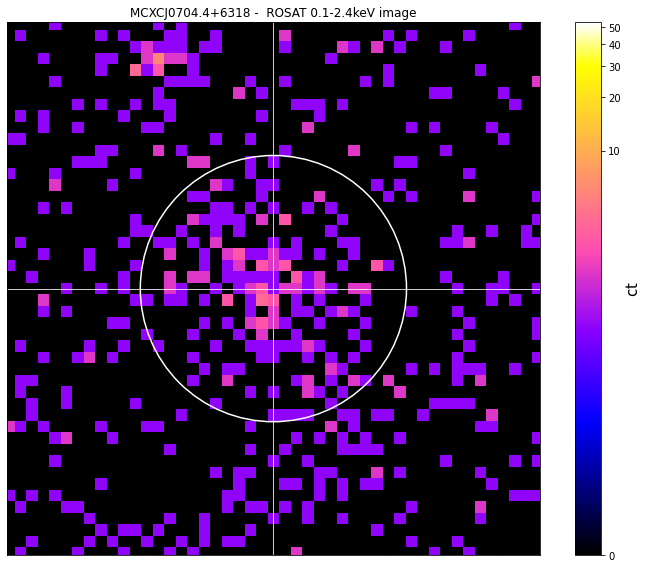

MCXCJ0726.0+4122


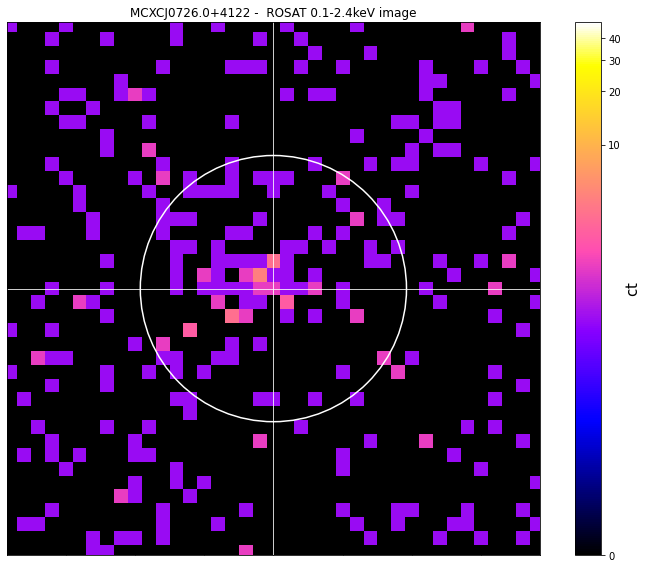

MCXCJ0736.4+3925


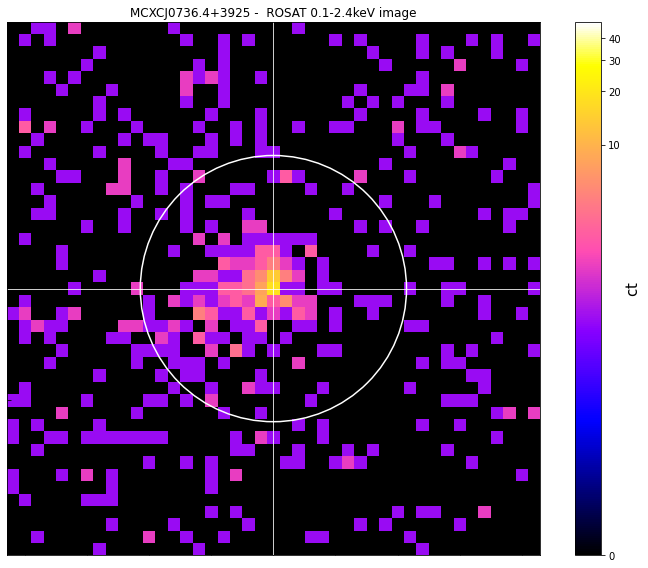

MCXCJ0759.7+5400


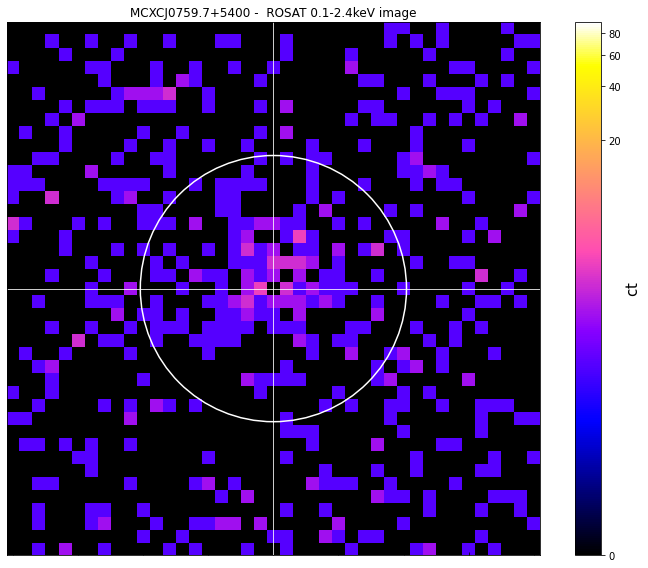

MCXCJ0819.6+6336


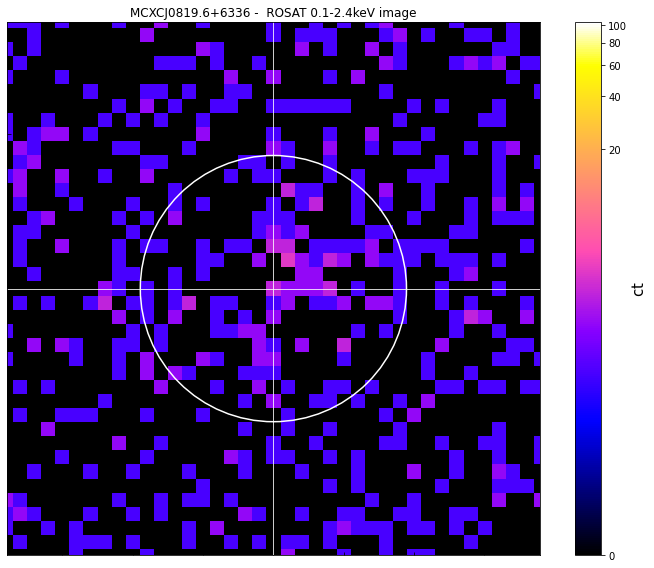

MCXCJ0821.0+0751


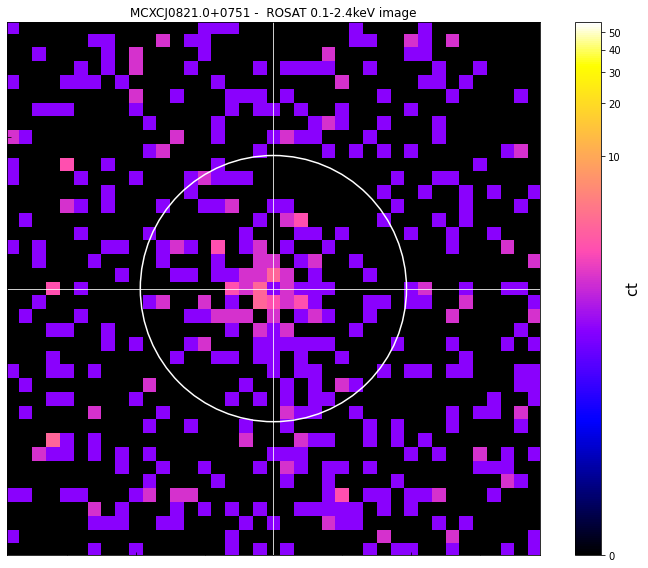

MCXCJ0912.4+1556


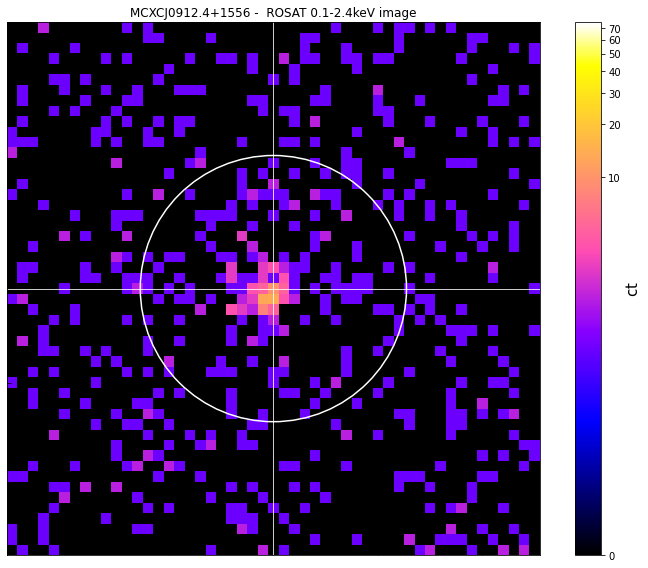

MCXCJ1006.6+2554


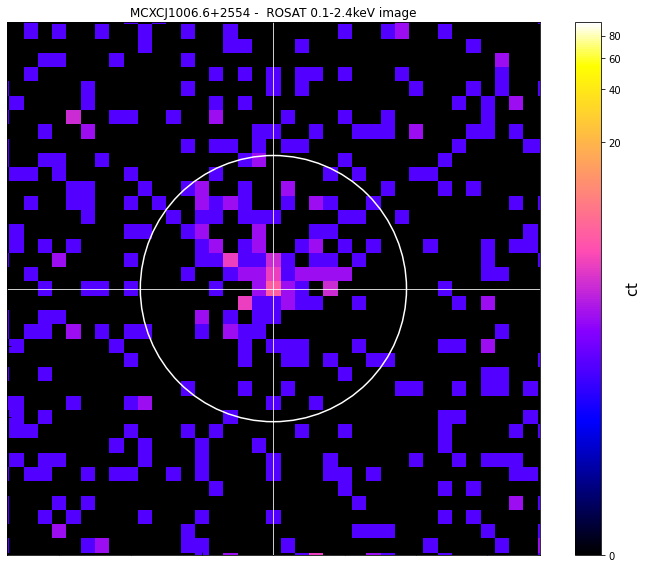

MCXCJ1027.9-0647


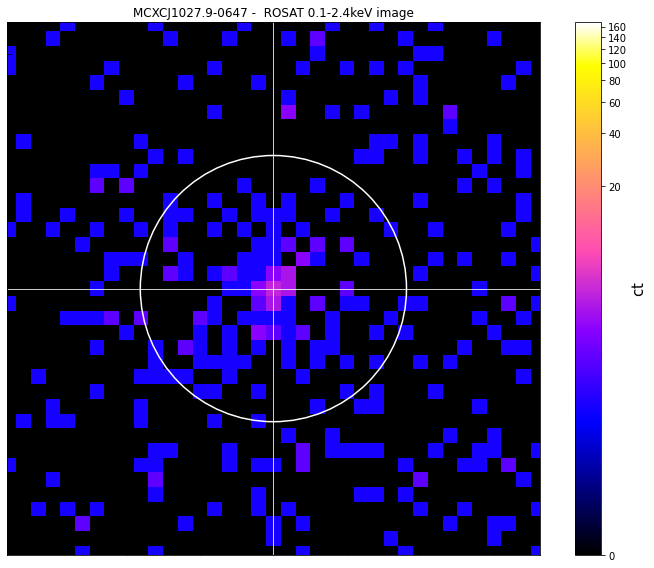

MCXCJ1130.3-1434


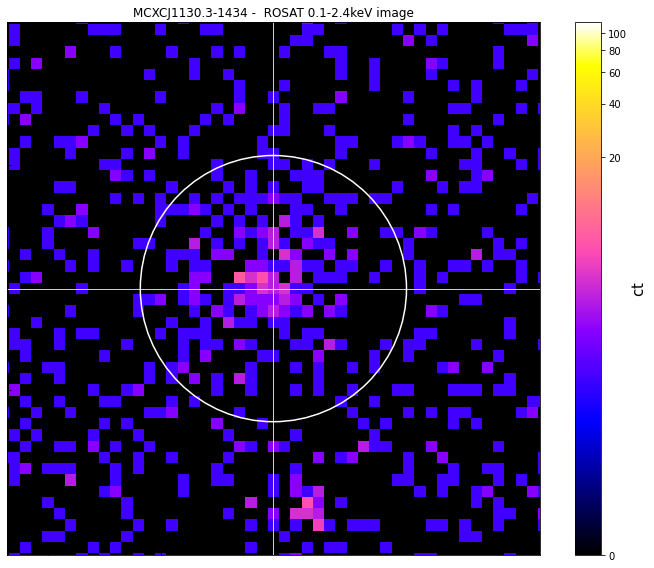

MCXCJ1139.4-3327


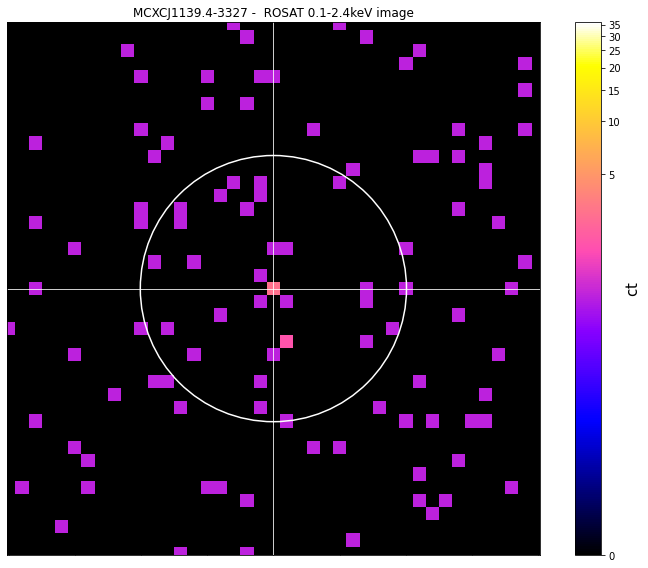

MCXCJ1143.5+4623


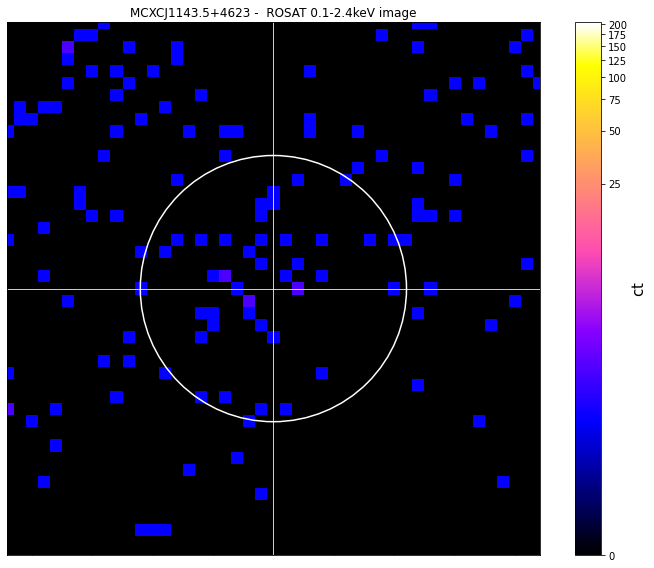

MCXCJ1144.6+6724


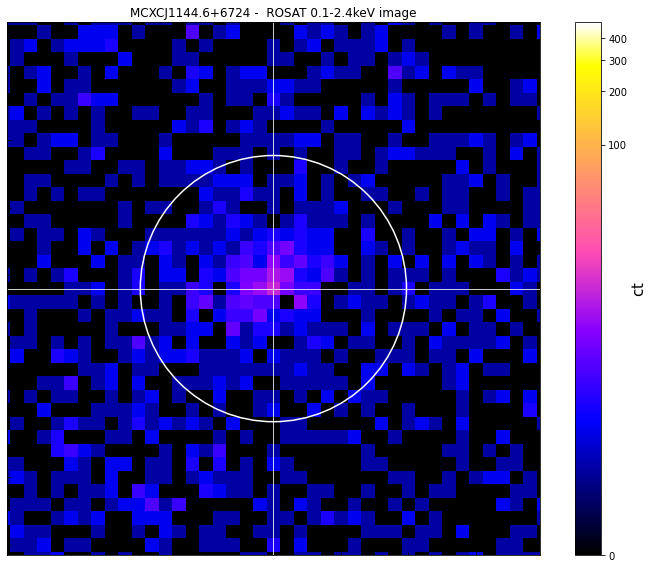

MCXCJ1215.4-3900


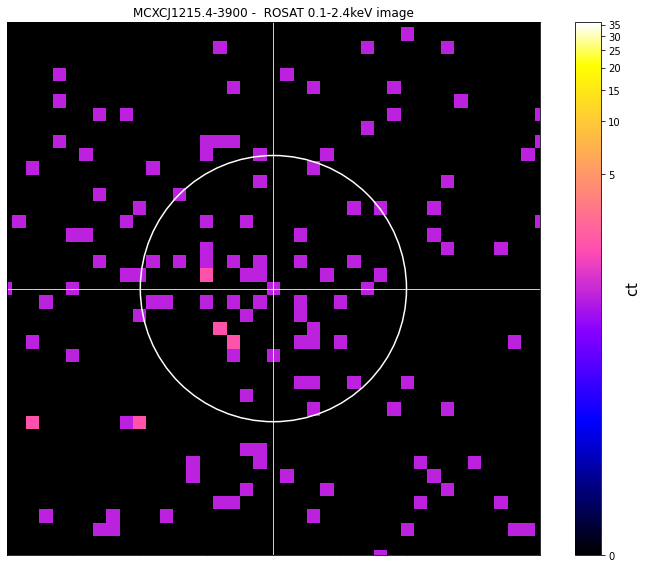

MCXCJ1332.9-2519


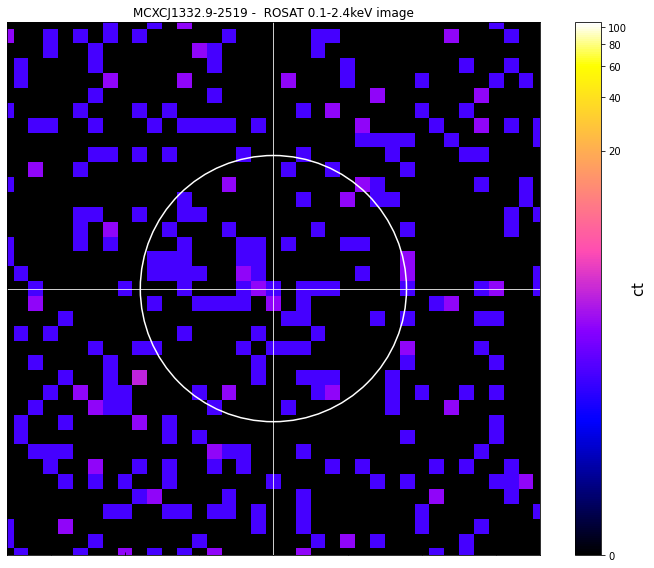

MCXCJ1336.1+5912


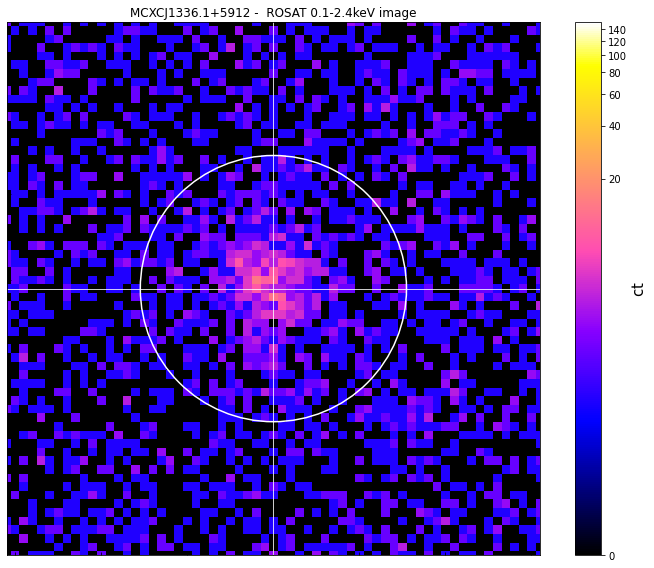

MCXCJ1416.8-1158


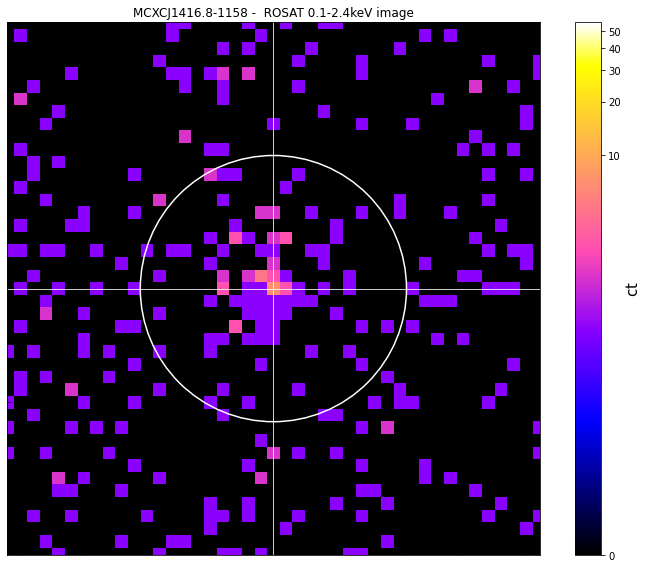

MCXCJ1431.1+2538


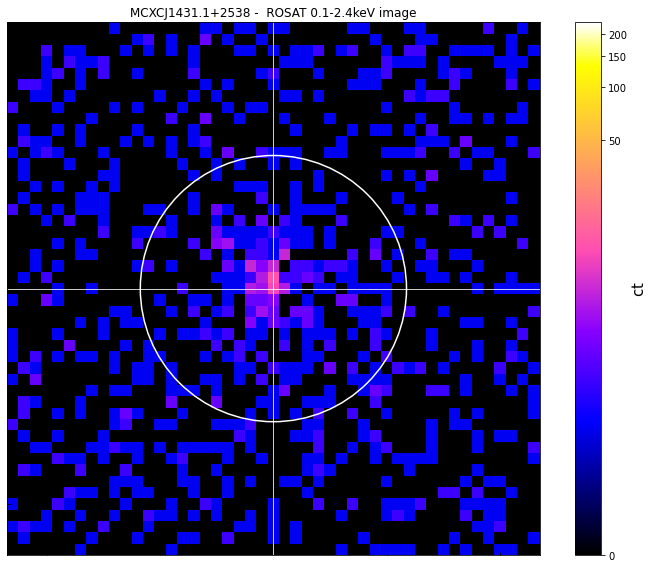

MCXCJ1459.0-0843


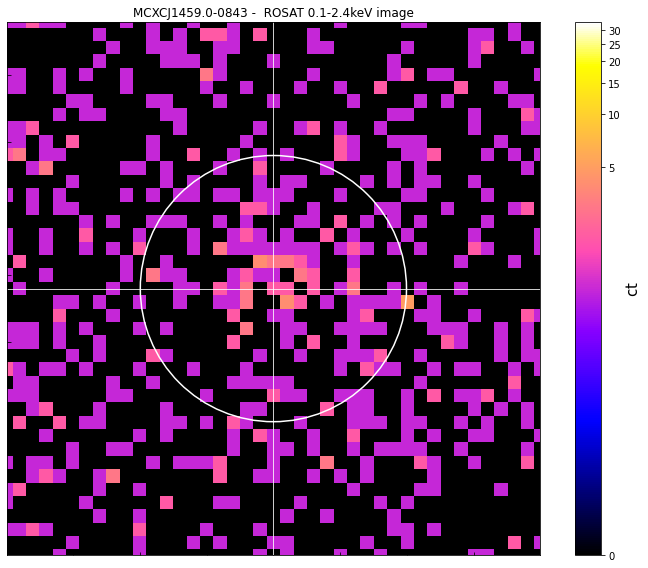

MCXCJ1516.5-0056


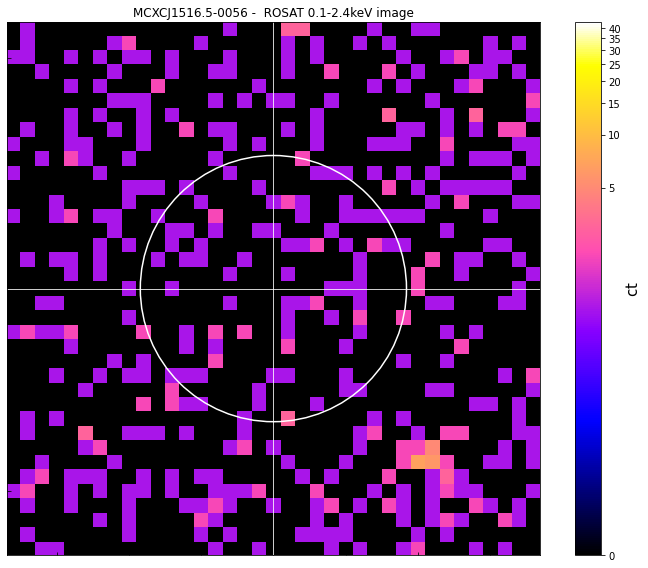

MCXCJ1520.9+4840


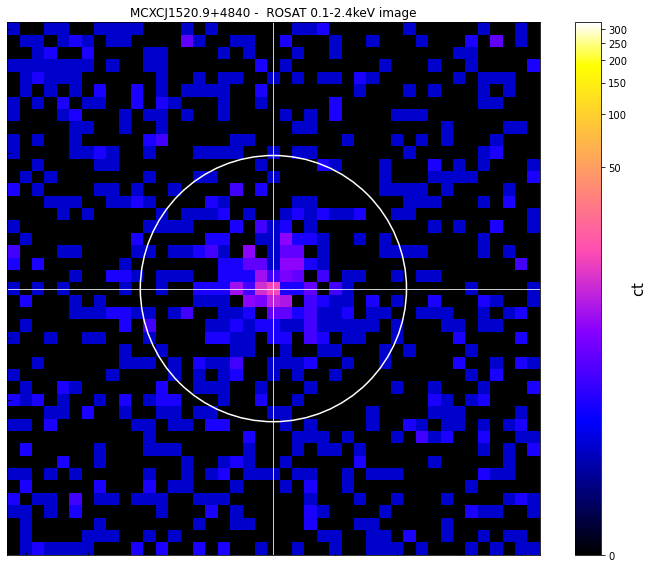

MCXCJ1539.8+3043


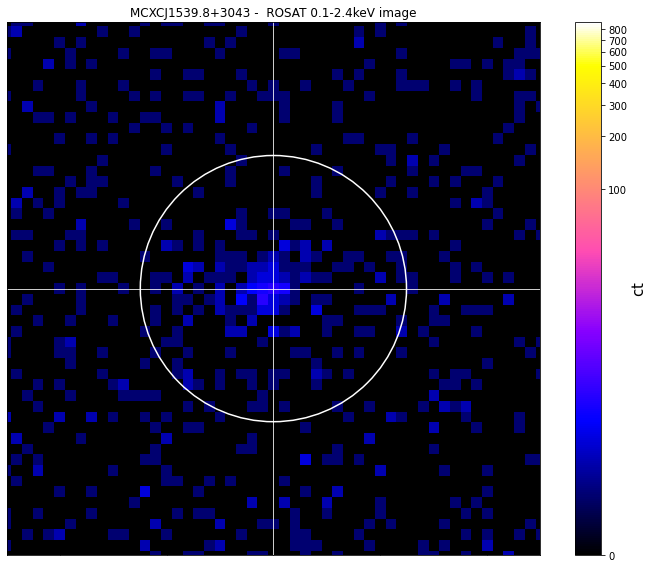

MCXCJ1601.3+5354


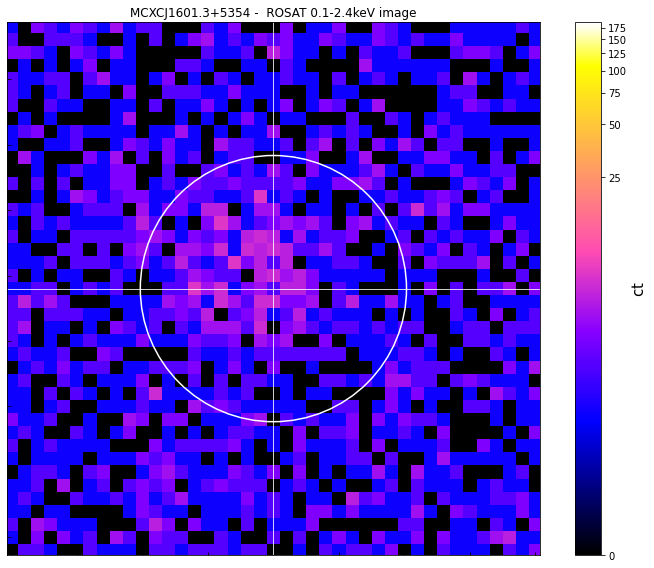

MCXCJ2125.2-0657


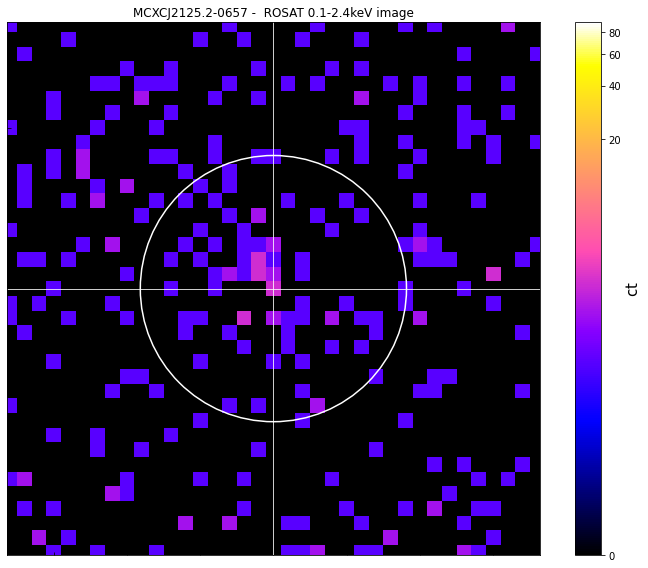

MCXCJ2250.3+1054


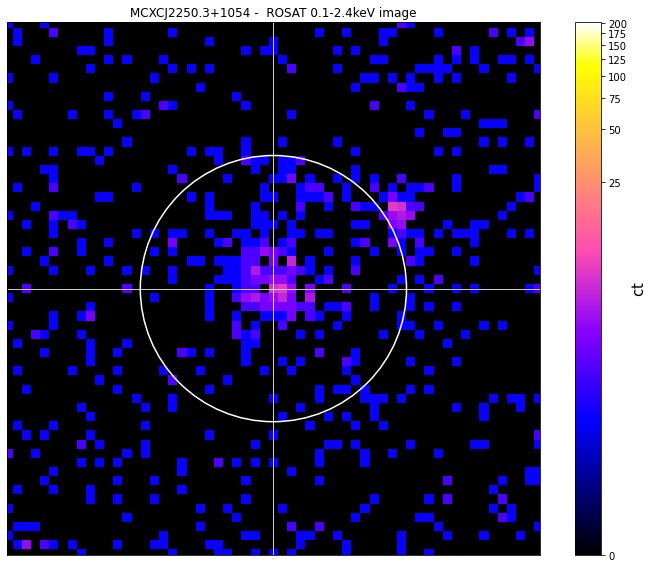

MCXCJ2350.5+2931


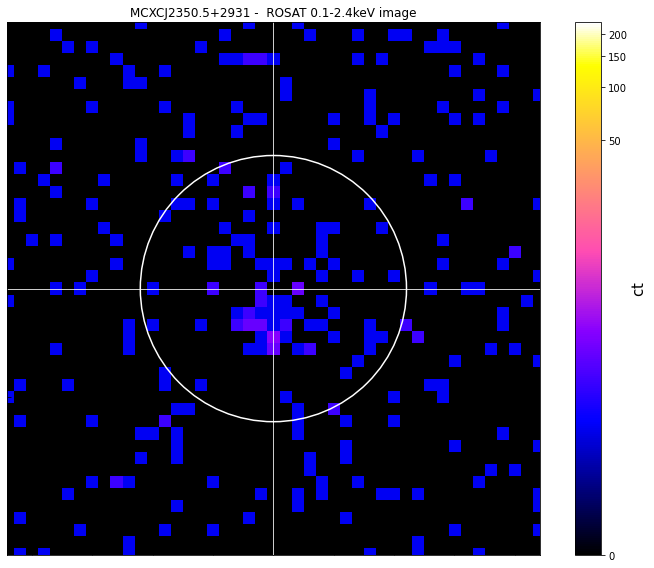

MCXCJ2359.9-3928


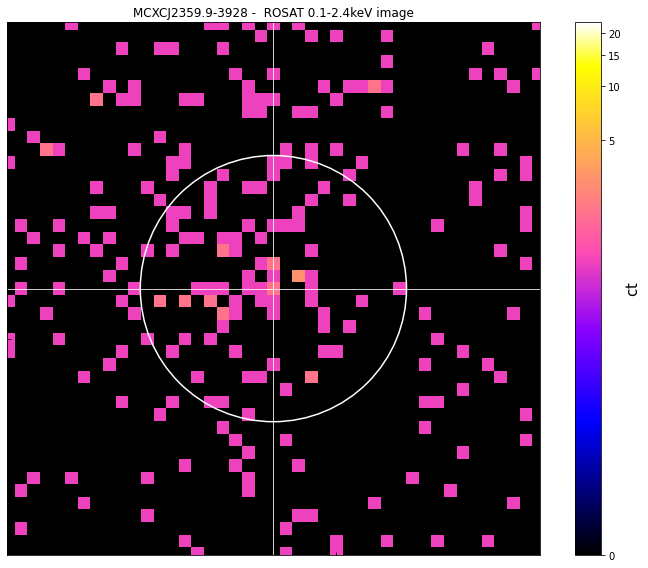

In [9]:
view_subsamp(unobs_samp)

### Notes

* MCXCJ1139.4-3327 - Very little emission apart from a single brighter pixel at the coordinates. Had a look on the legacy survey and I would say that there is a cluster there, though I'm more used to looking for higher redshift clusters.
* MCXCJ1143.5+4623 - Fairly flat emission. Again looked at the legacy survey and I see cluster type galaxies. Some of them have SDSS spectroscopy and the three that do are around the redshift this cluster is meant to be at. There is also a massive BCG-type galaxy at that redshift.
* MCXCJ1215.4-3900 - Very little ROSAT emission, but I could convince myself there is something.
* MCXCJ1332.9-2519 - Pretty flat, again maybe I could convince myself but maybe not. Legacy survey wise there is probably a cluster there, but its not as convincing as the others that I have checked.
* MCXCJ1516.5-0056 - Fairly flat in ROSAT. There are few galaxies with SDSS spectroscopy on legacy survey (with redshifts similar to the cluster redshift), so pretty sure that this is a cluster.
* MCXCJ2359.9-3928 - Not much X-ray emission. Nice set of cluster type galaxies, with a large BCG esque galaxy in legacy survey viewer.

## RASS images of the clusters observed by XMM

MCXCJ0005.3+1612


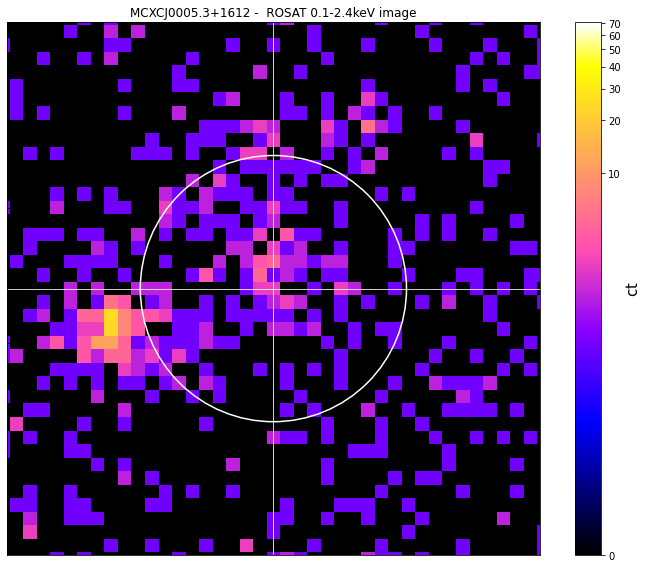

MCXCJ0006.0-3443


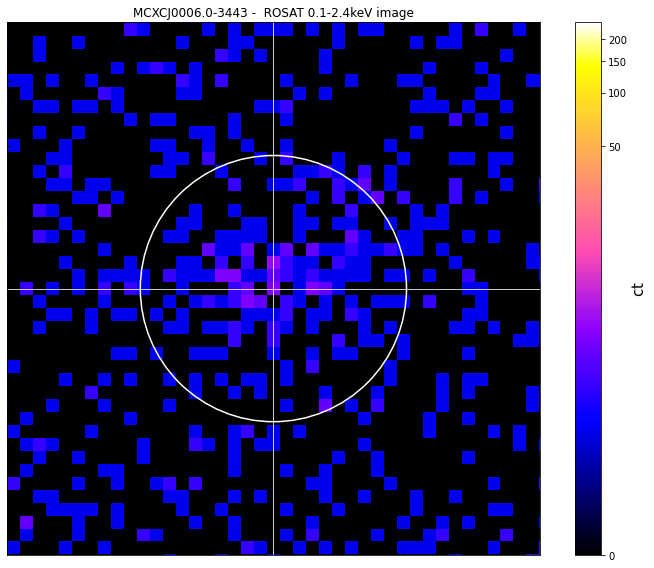

MCXCJ0011.3-2851


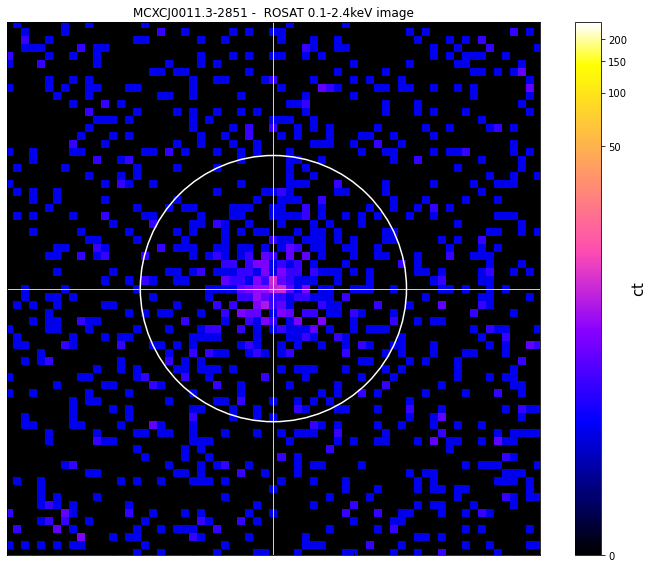

MCXCJ0011.7+3225


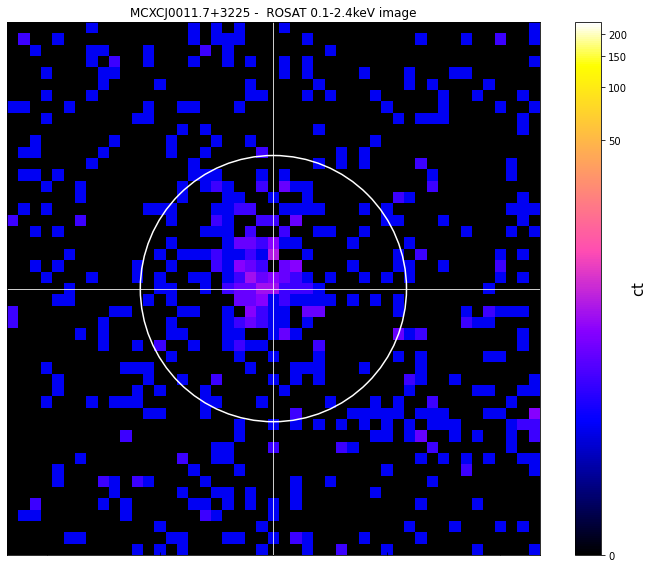

MCXCJ0013.6-1930


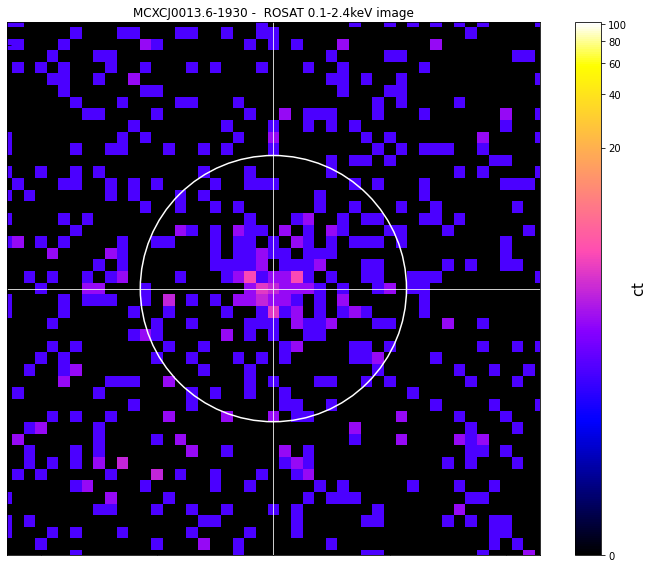

MCXCJ0020.6+2840


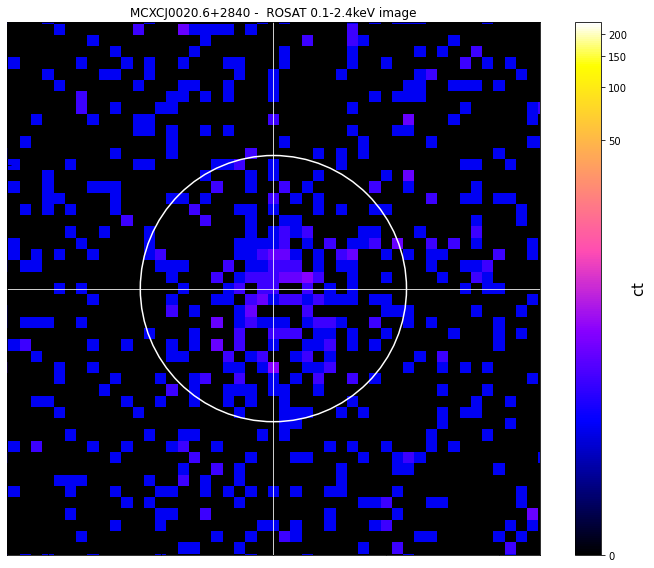

MCXCJ0034.2-0204


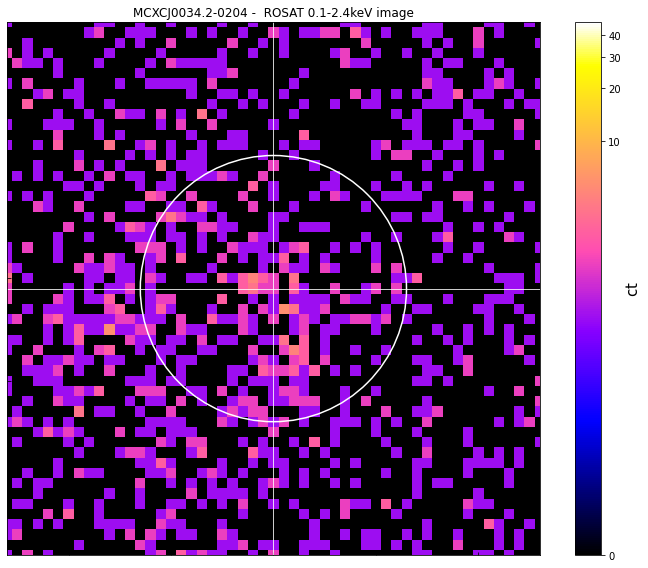

MCXCJ0034.6-0208


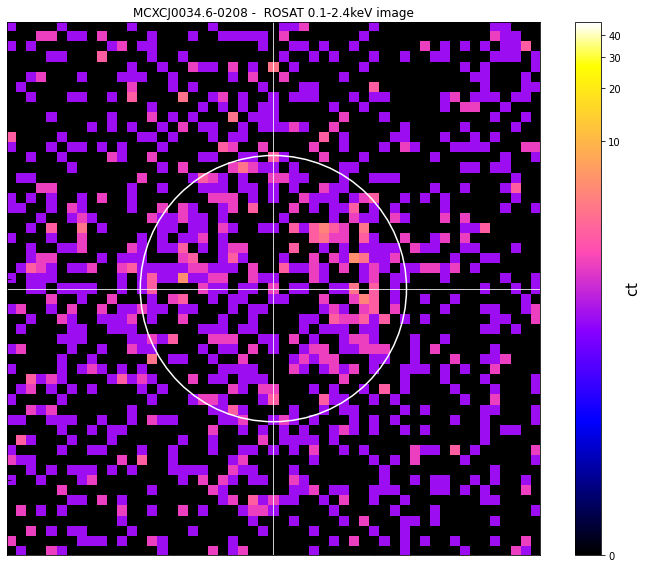

MCXCJ0041.8-0918


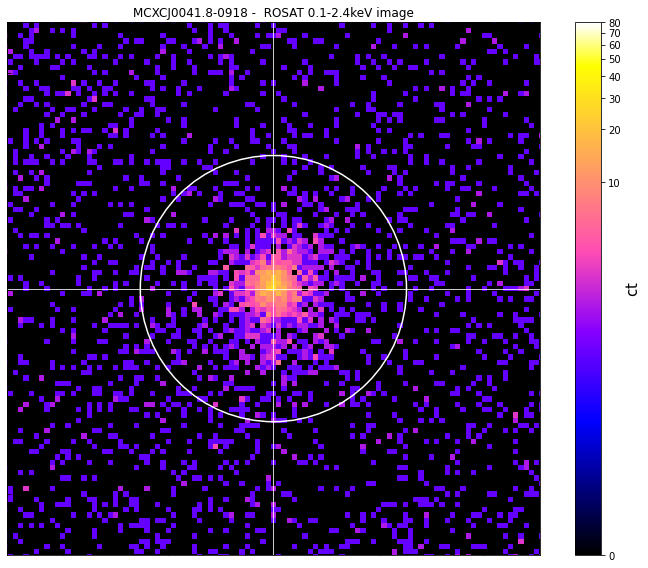

MCXCJ0042.1-2832


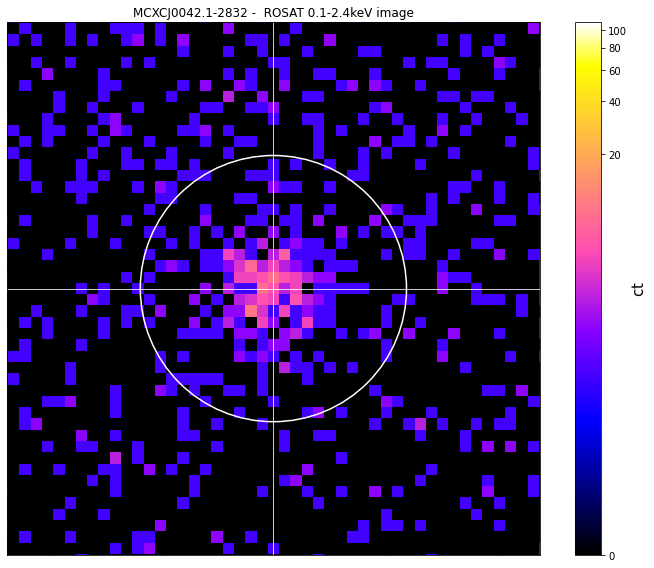

MCXCJ0049.4-2931


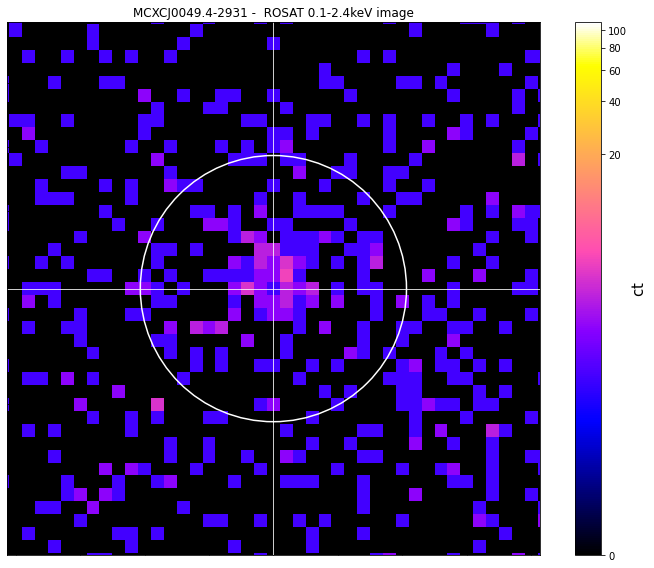

MCXCJ0056.3-0112


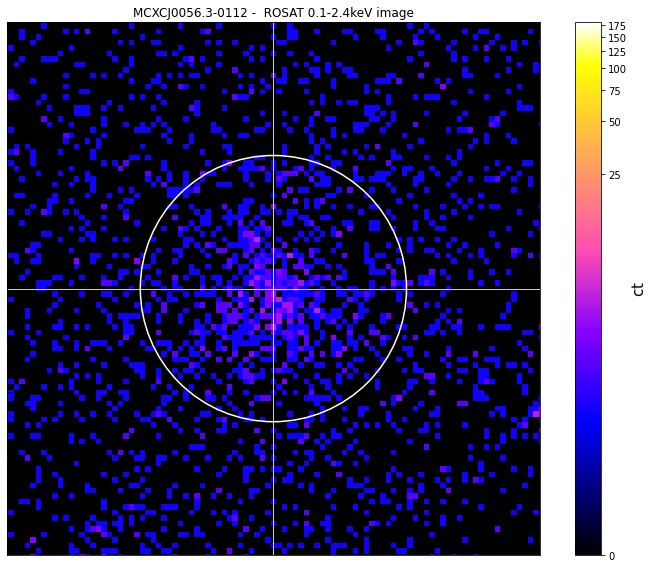

MCXCJ0102.7-2152


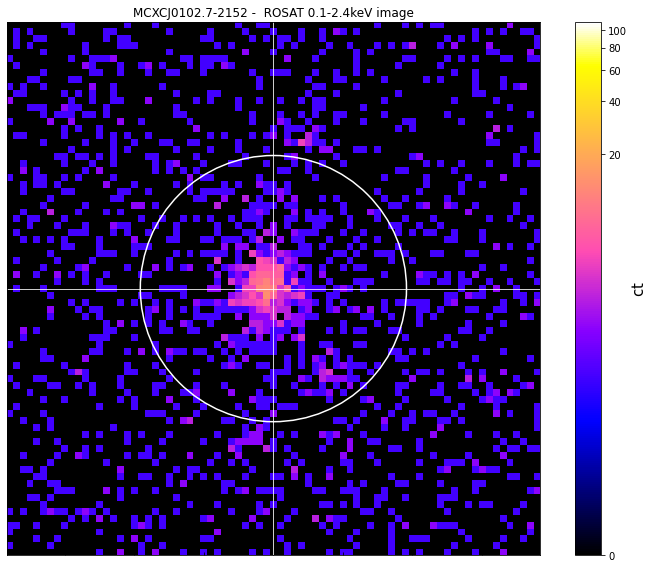

MCXCJ0145.0-5300


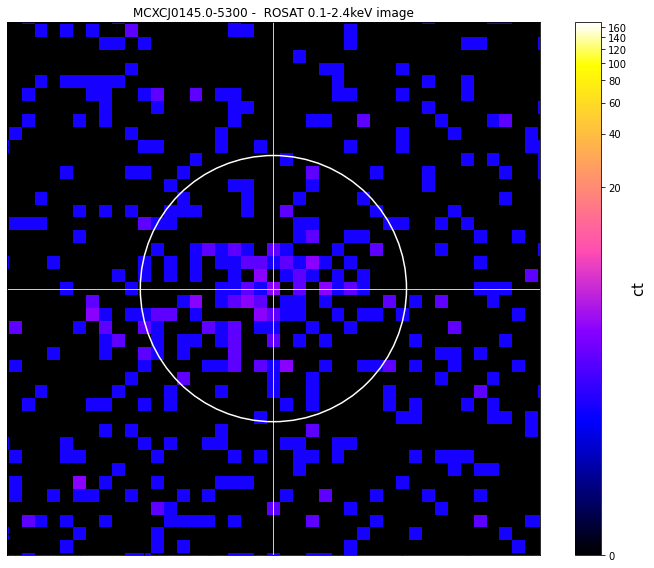

MCXCJ0155.1+3355


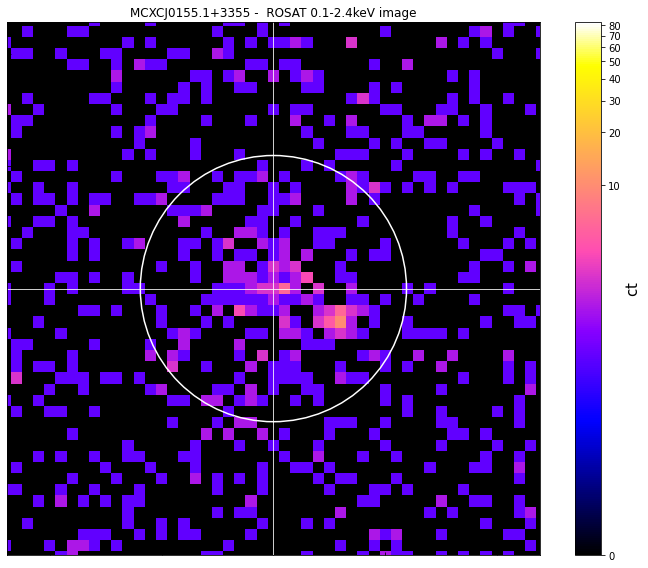

MCXCJ0257.8+1302


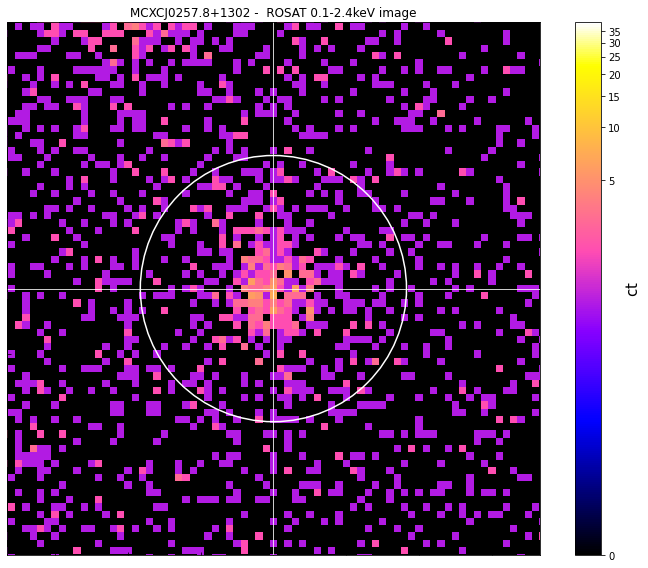

MCXCJ0258.9+1334


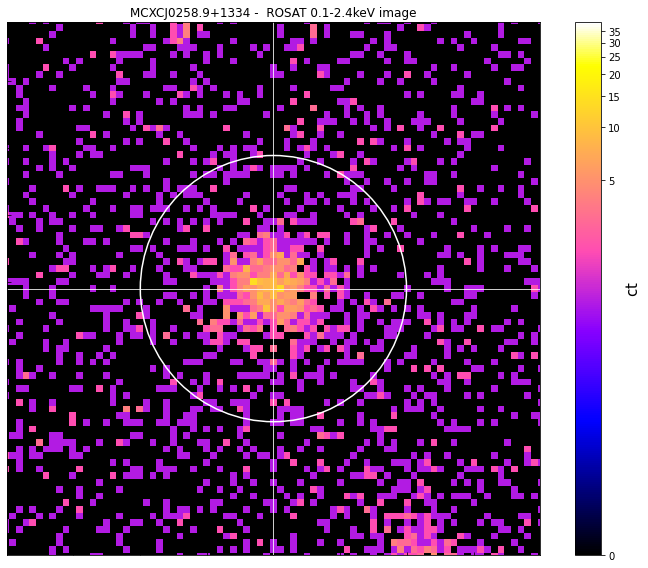

MCXCJ0314.3-4525


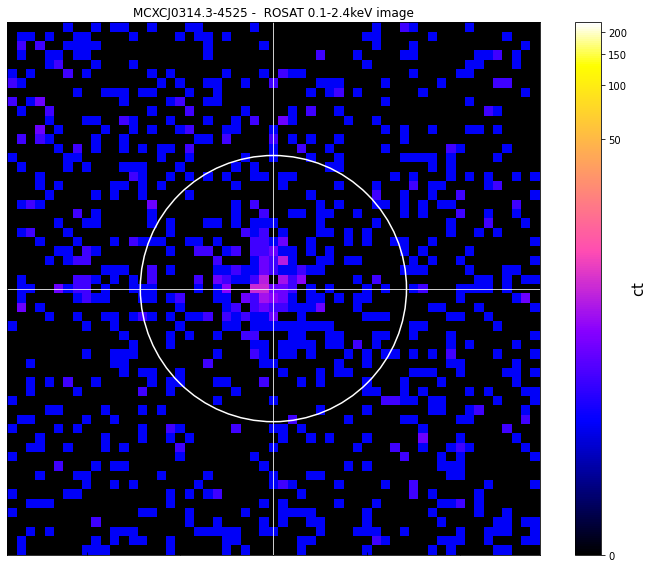

MCXCJ0317.9-4414


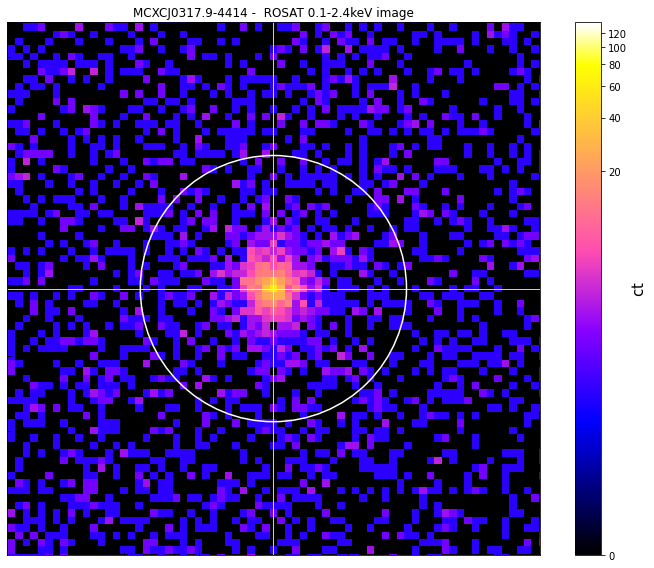

MCXCJ0328.6-5542


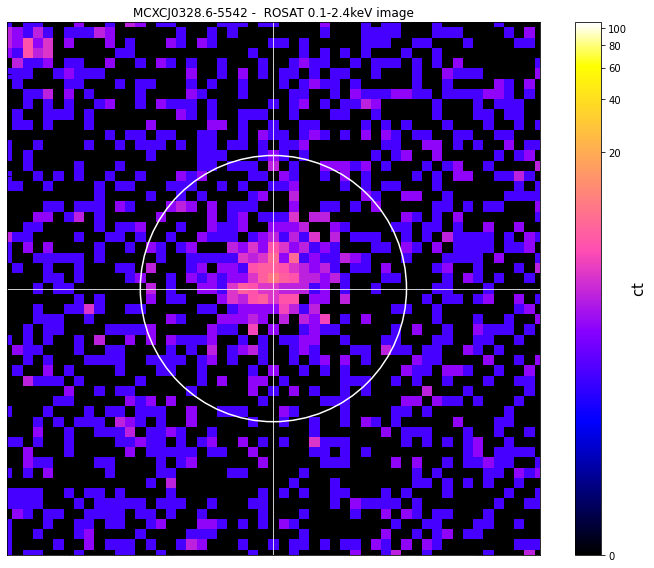

MCXCJ0330.0-5235


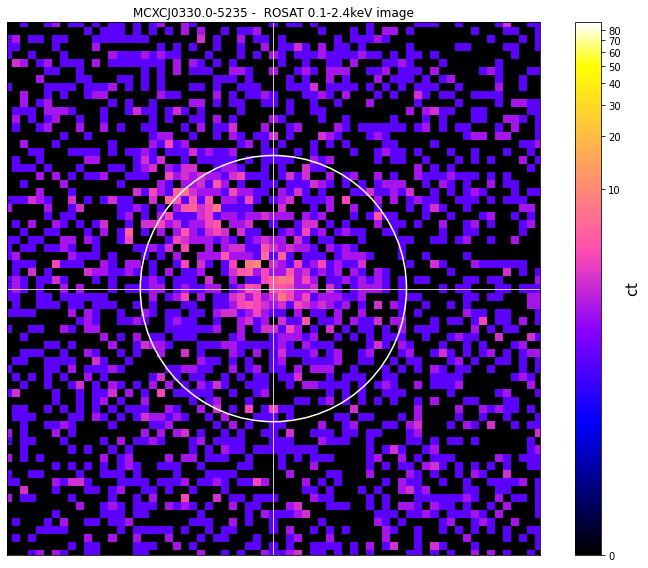

MCXCJ0342.8-5338


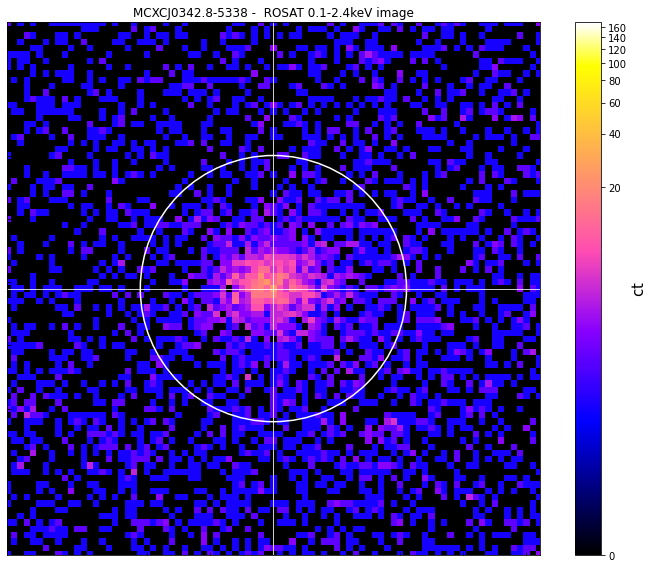

MCXCJ0345.9-2416


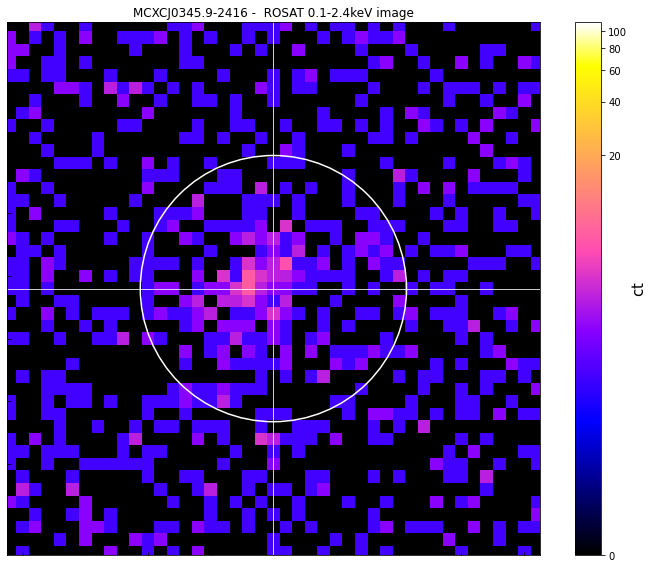

MCXCJ0425.8-0833


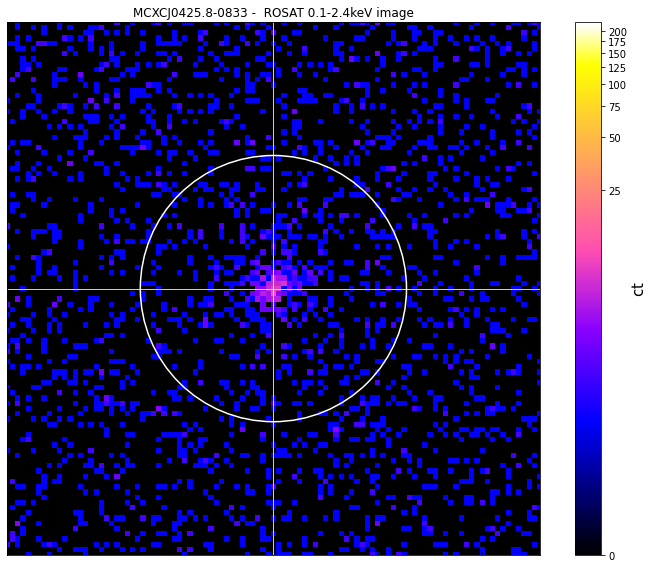

MCXCJ0431.4-6126


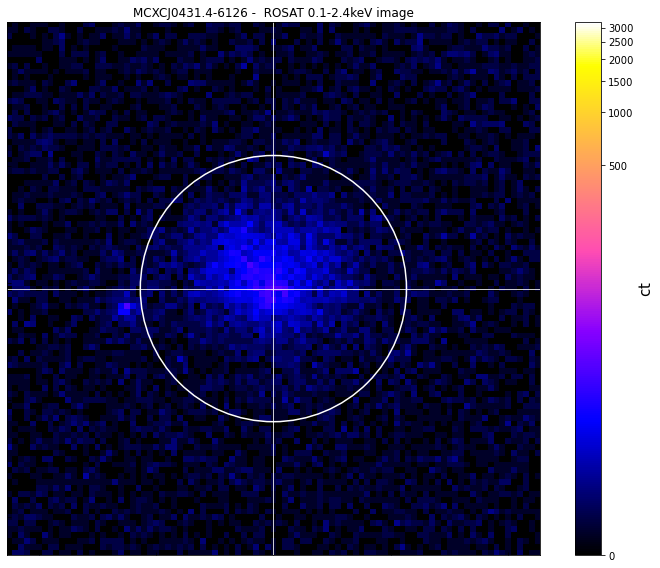

MCXCJ0433.6-1315


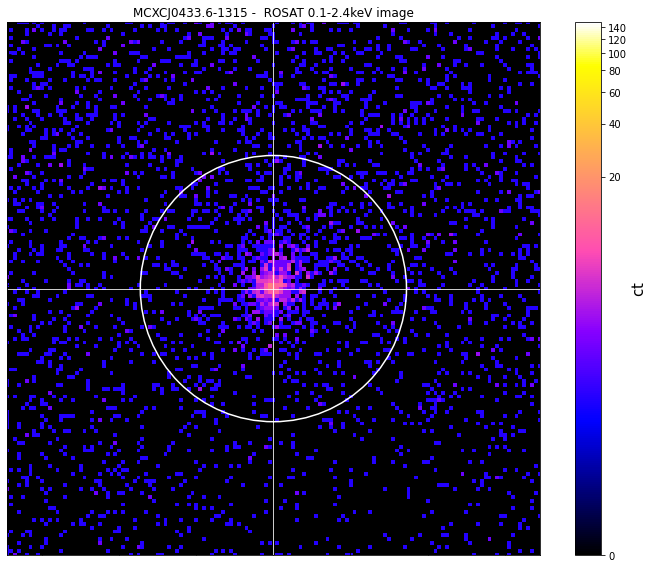

MCXCJ0448.2-2028


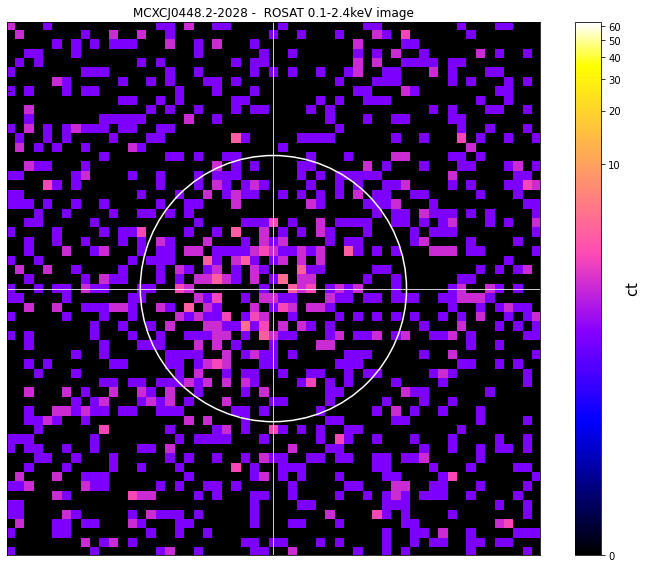

MCXCJ0909.1-0939


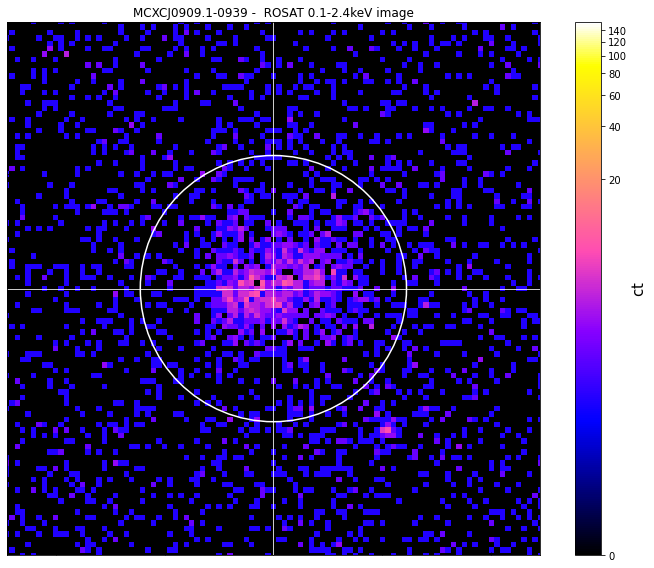

MCXCJ0910.6-1034


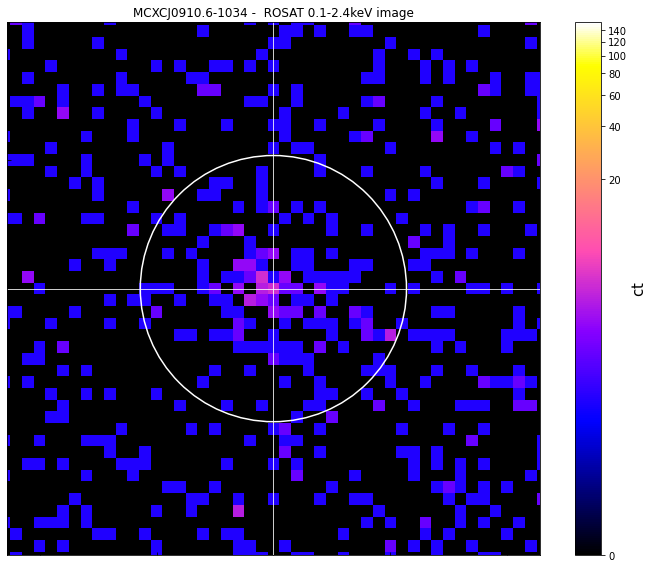

MCXCJ0918.1-1205


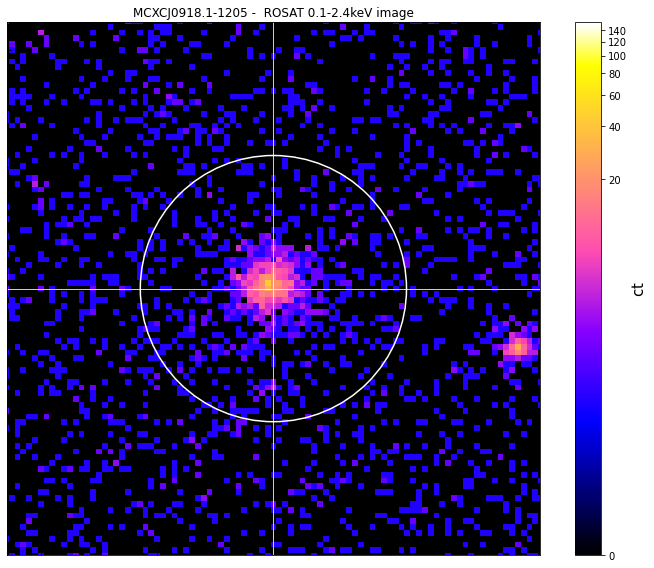

MCXCJ1111.6+4050


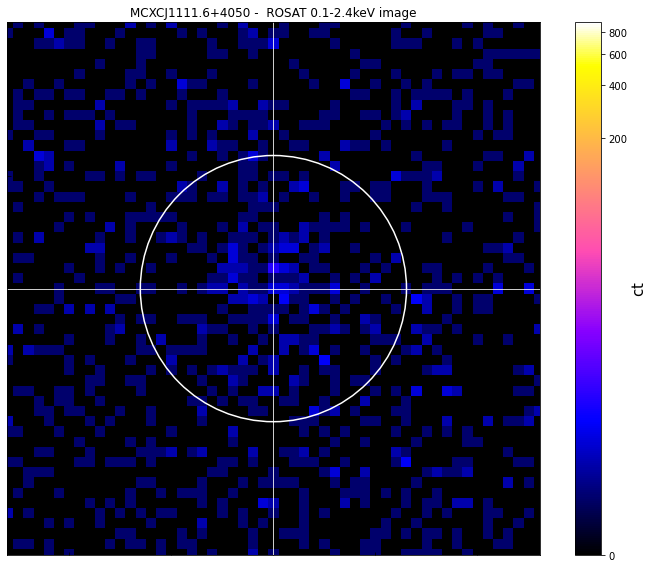

MCXCJ1113.3+0231


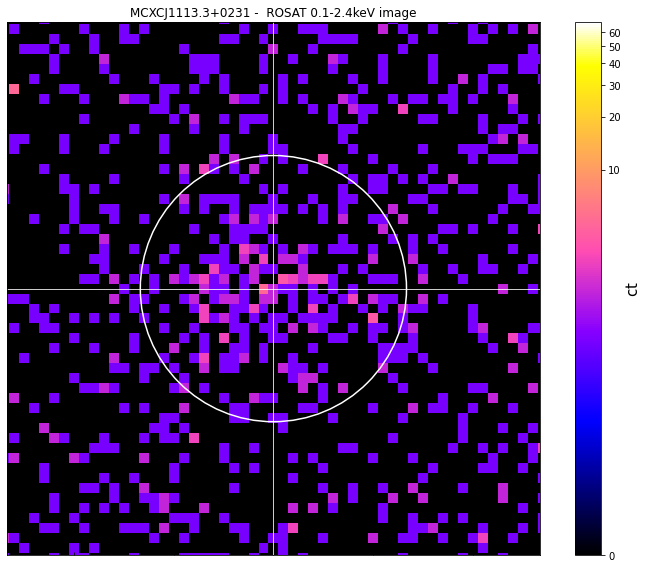

MCXCJ1132.8+1428


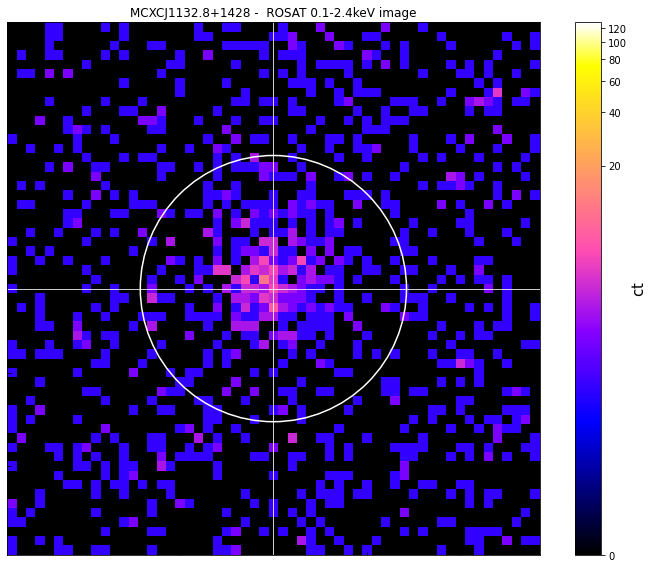

MCXCJ1133.2+6622


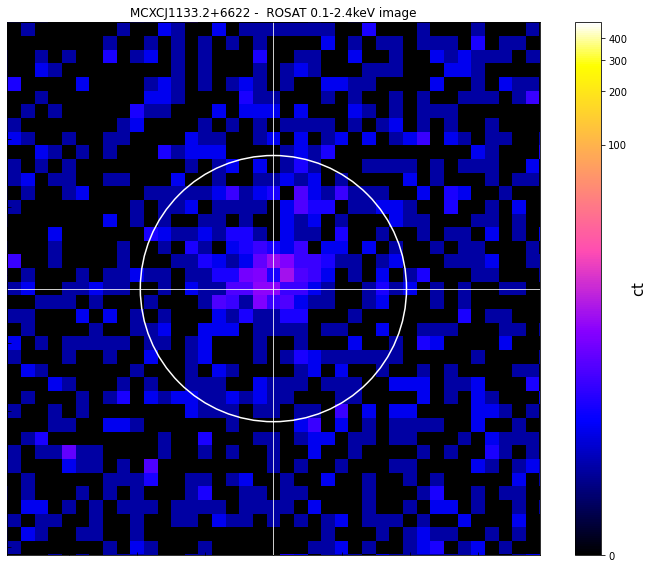

MCXCJ1141.4-1216


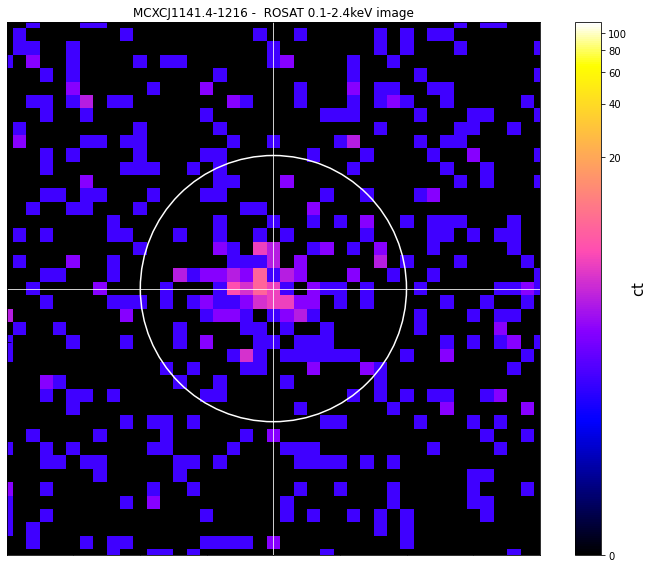

MCXCJ1217.6+0339


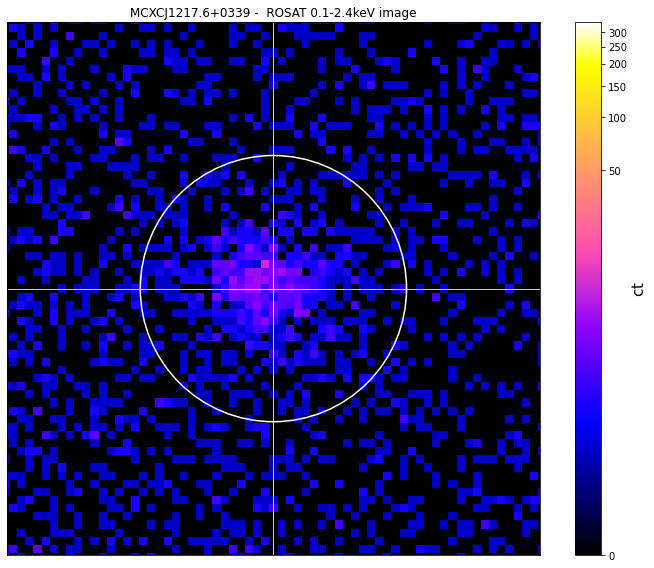

MCXCJ1244.6-1159


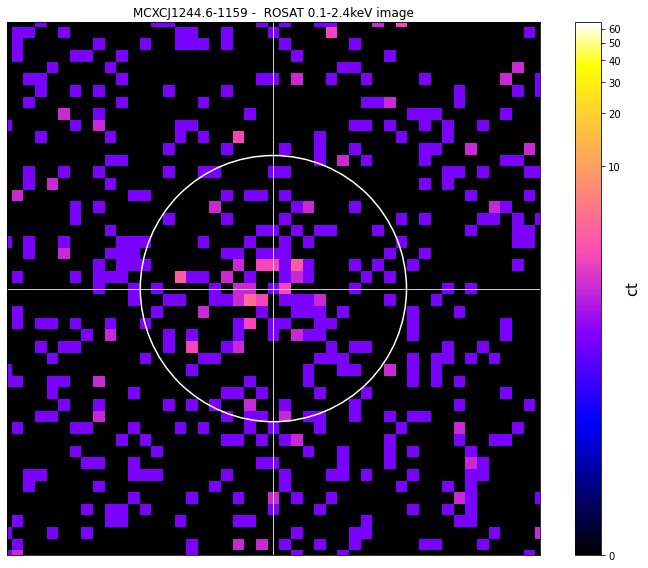

MCXCJ1254.6-2913


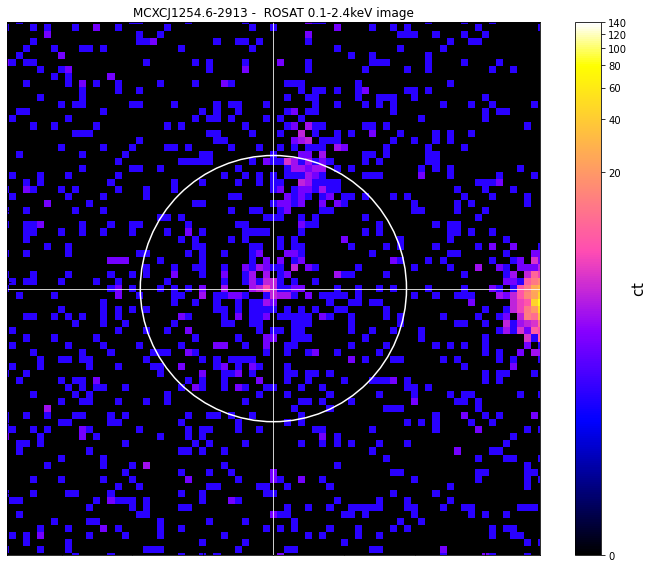

MCXCJ1257.1-1724


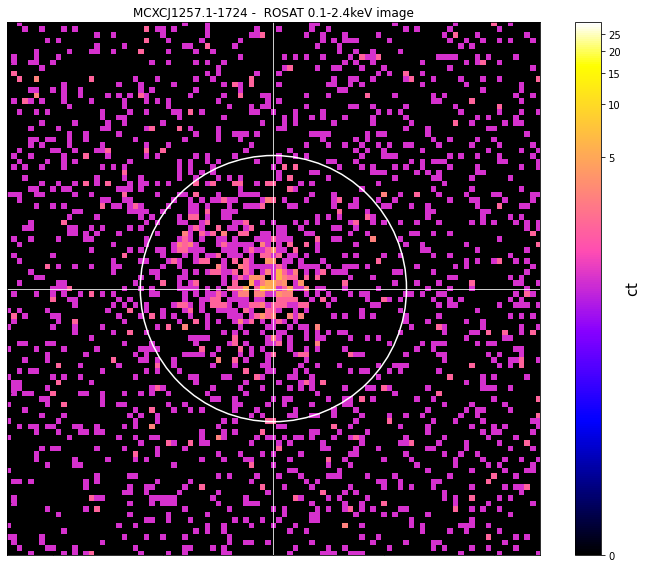

MCXCJ1257.2-3022


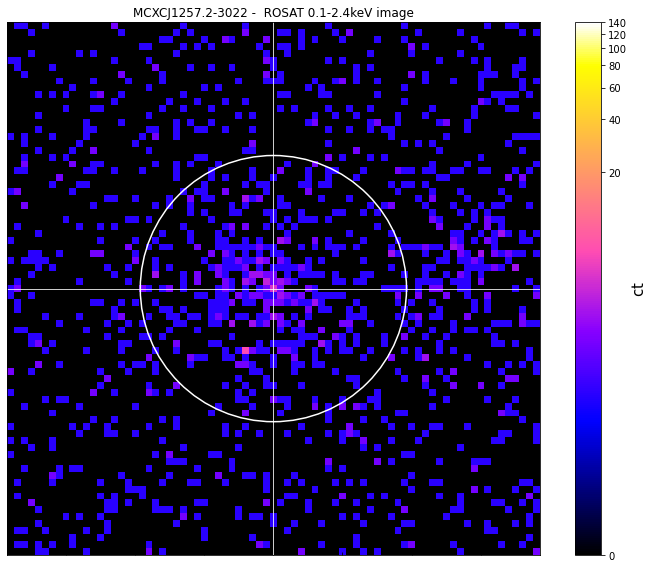

MCXCJ1258.6-0145


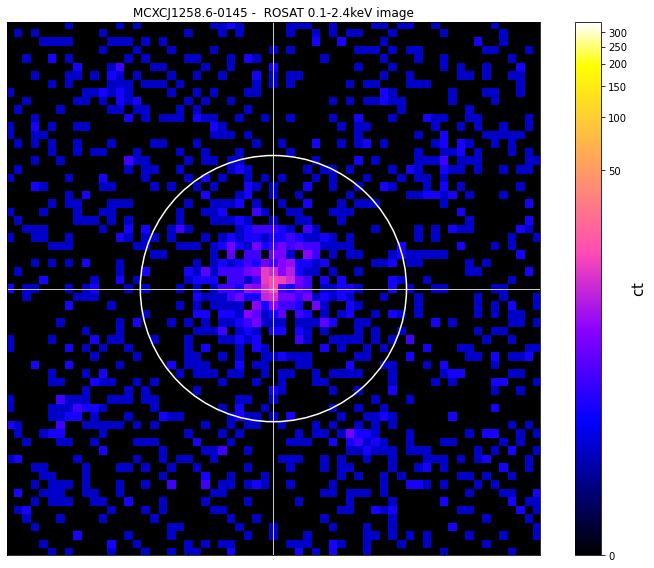

MCXCJ1259.3-0411


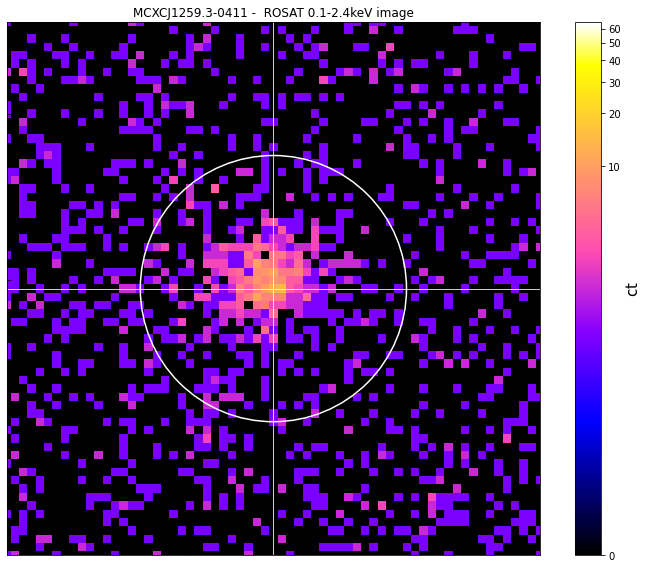

MCXCJ1326.9-2710


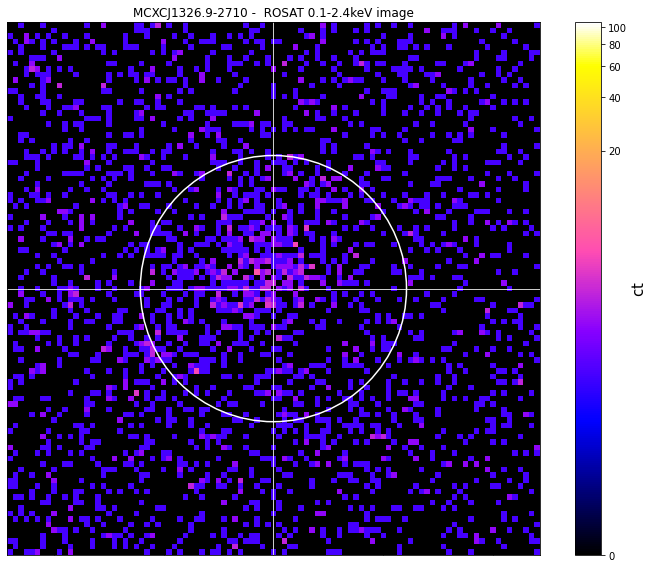

MCXCJ1327.9-3130


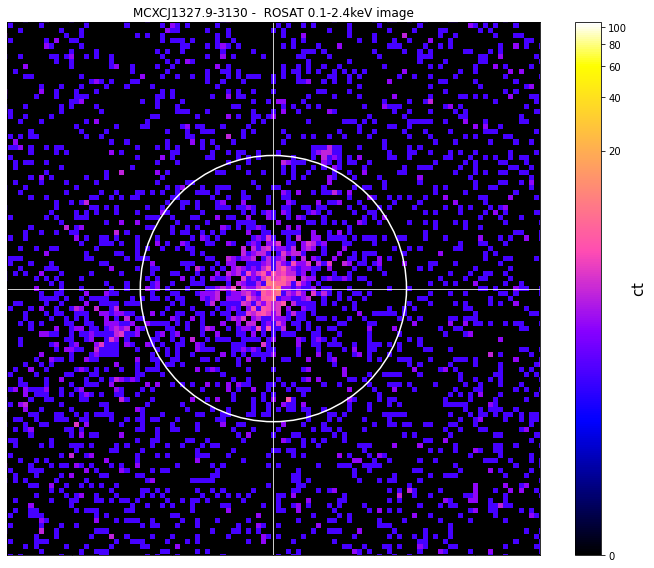

MCXCJ1330.8-0152


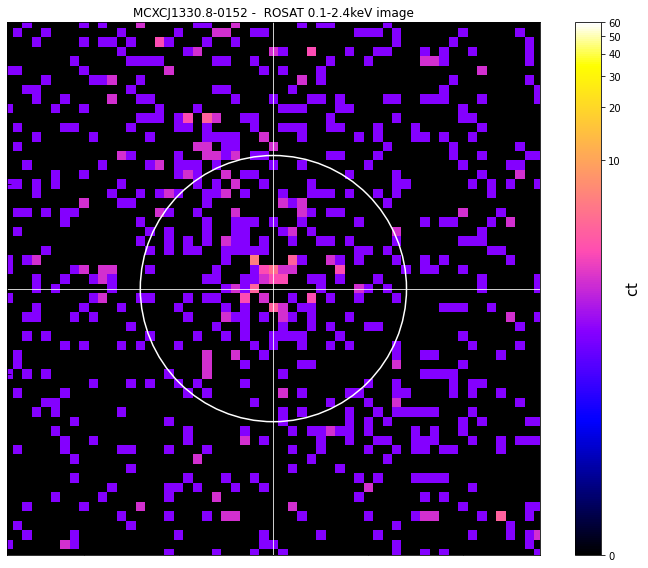

MCXCJ1341.8+2622


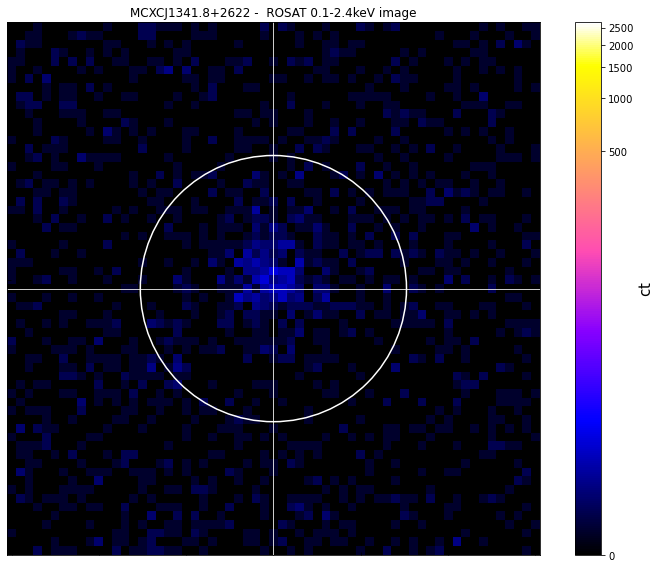

MCXCJ1347.4-3250


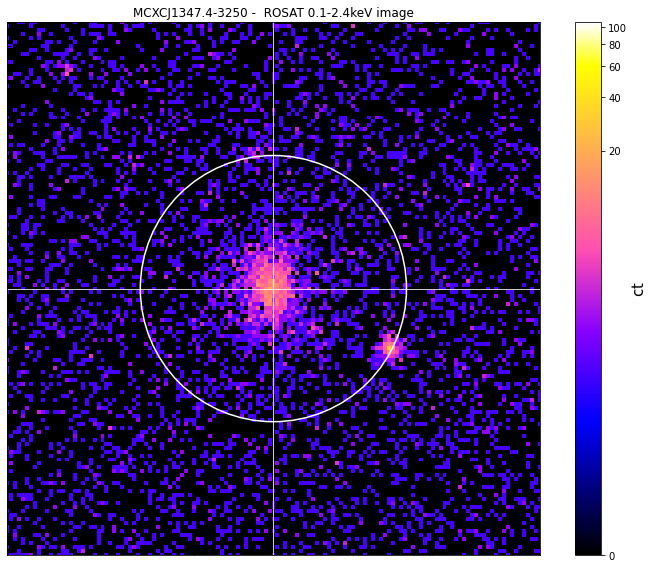

MCXCJ1348.8+2635


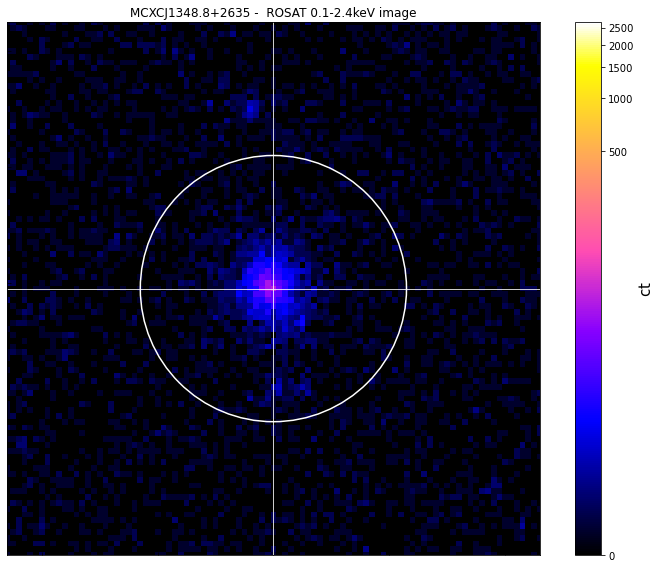

MCXCJ1349.3+2806


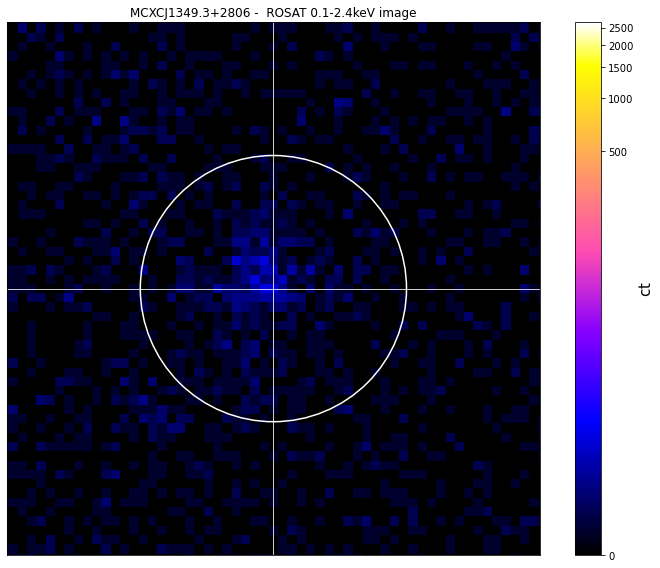

MCXCJ1353.0+0509


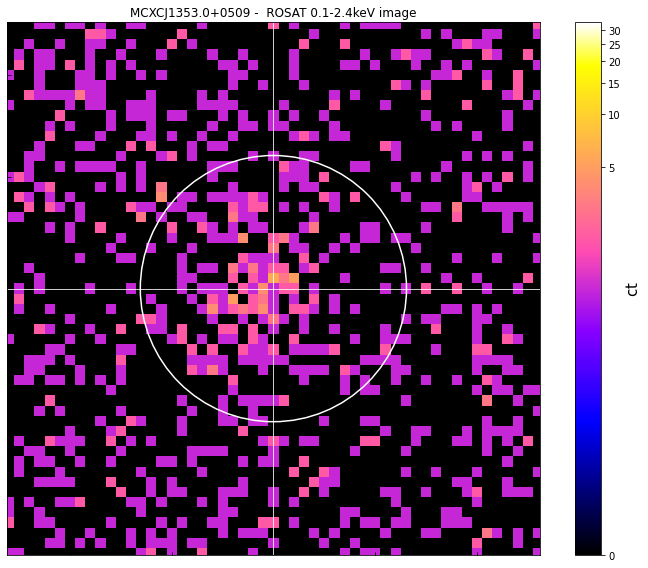

MCXCJ1359.2+2758


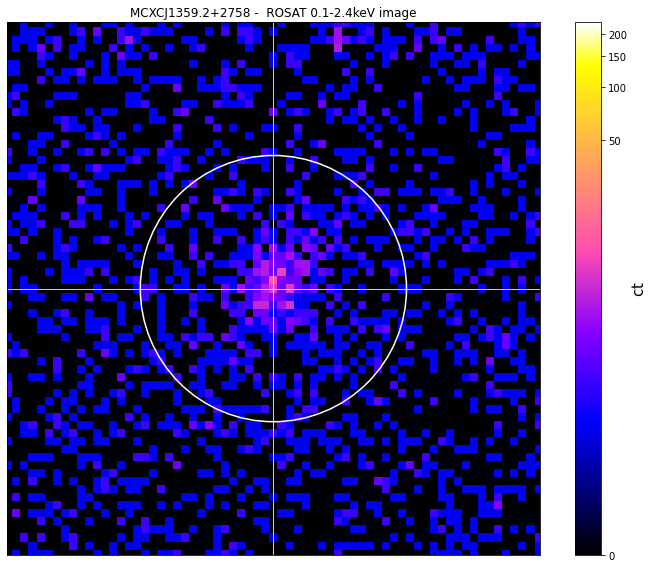

MCXCJ1413.7+4339


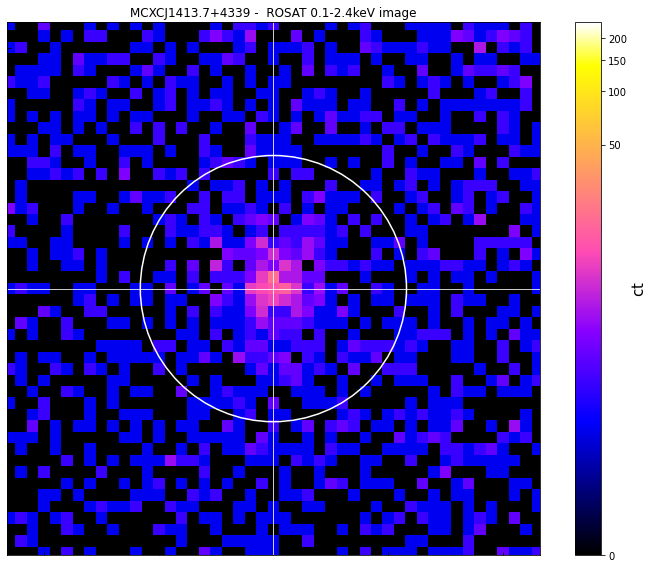

MCXCJ1442.3+2218


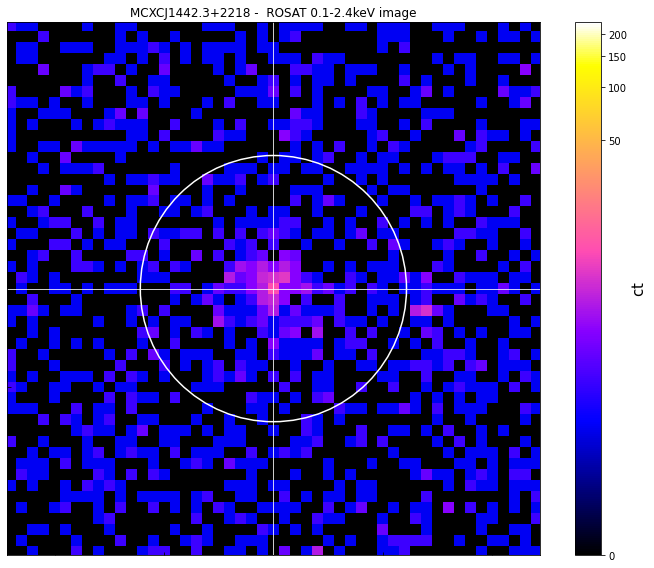

MCXCJ1510.1+3330


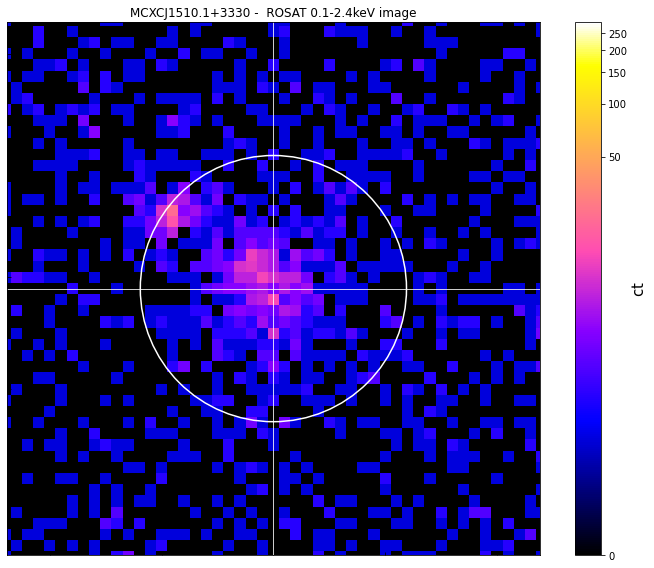

MCXCJ1510.9+0543


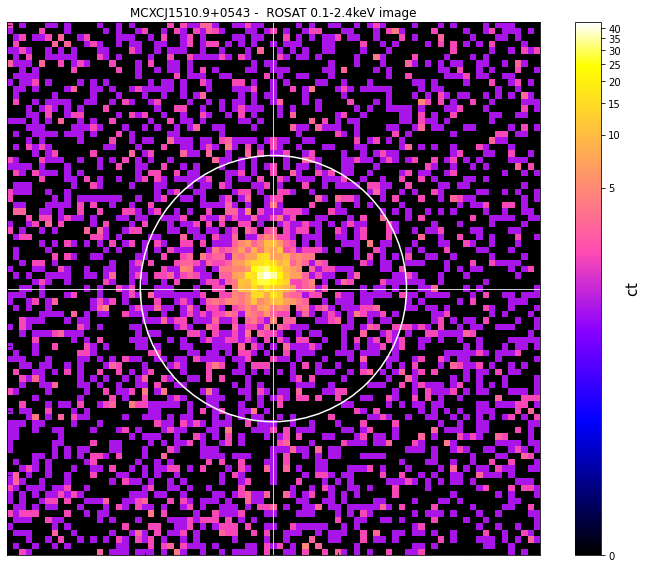

MCXCJ1511.3+0619


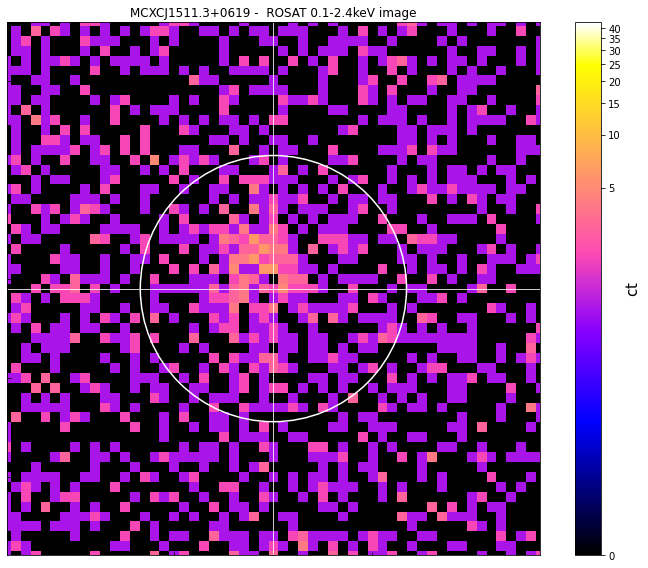

MCXCJ1516.3+0005


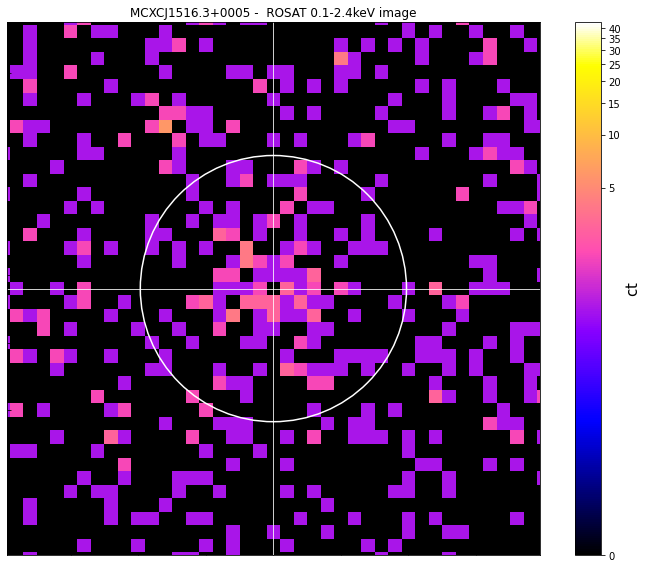

MCXCJ1516.7+0701


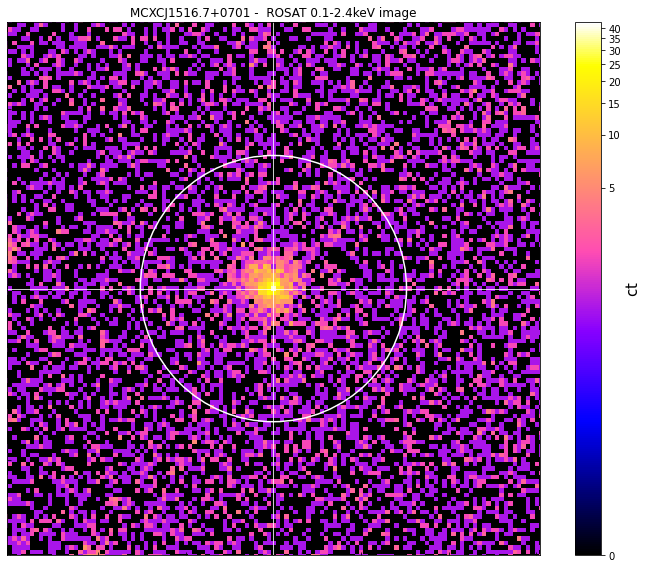

MCXCJ1518.7+0613


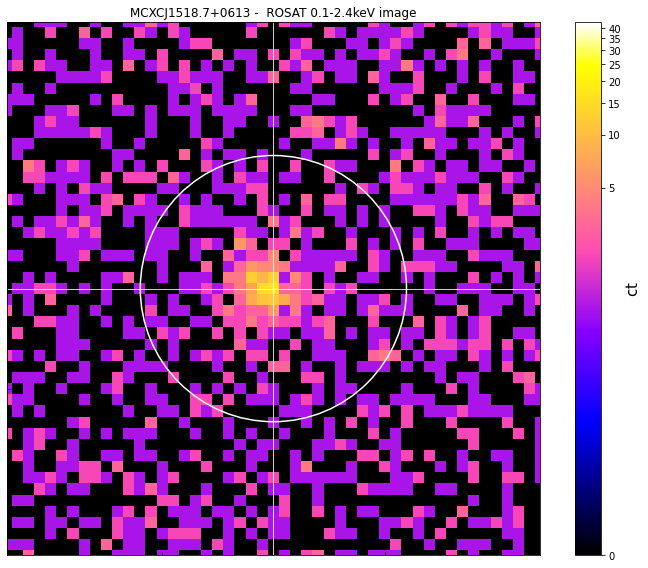

MCXCJ1521.2+3038


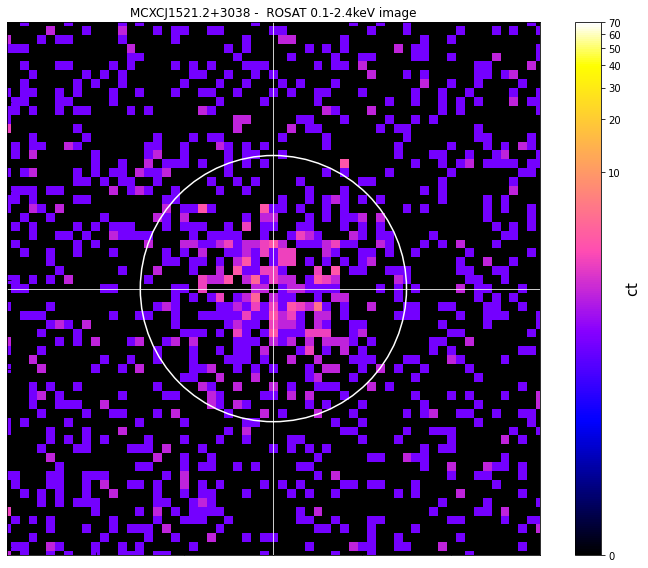

MCXCJ1521.8+0742


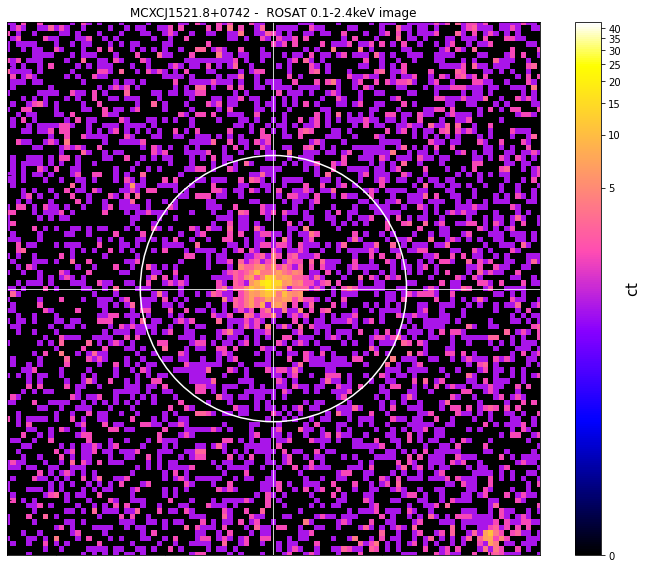

MCXCJ1522.4+2742


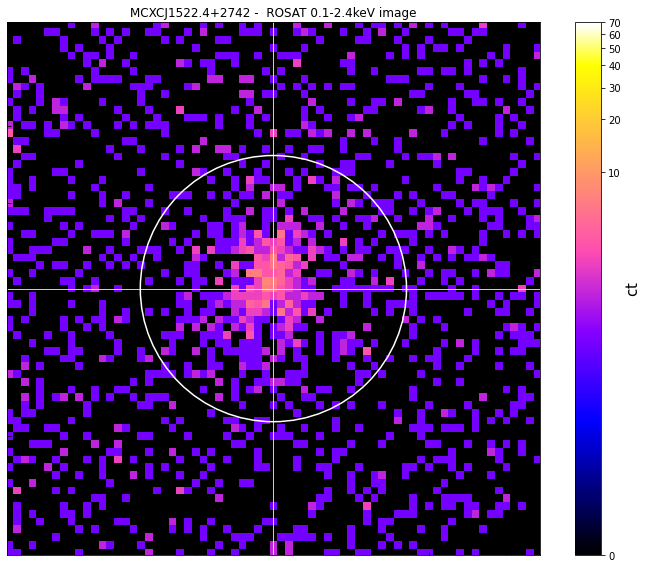

MCXCJ1523.0+0836


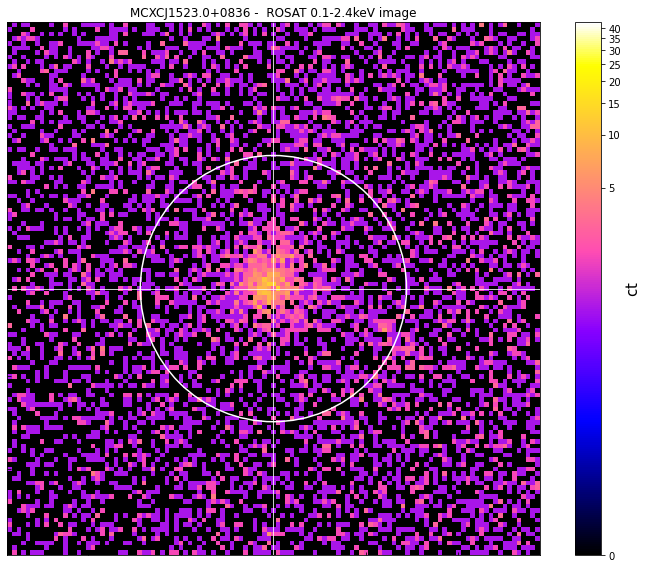

MCXCJ1524.1+2955


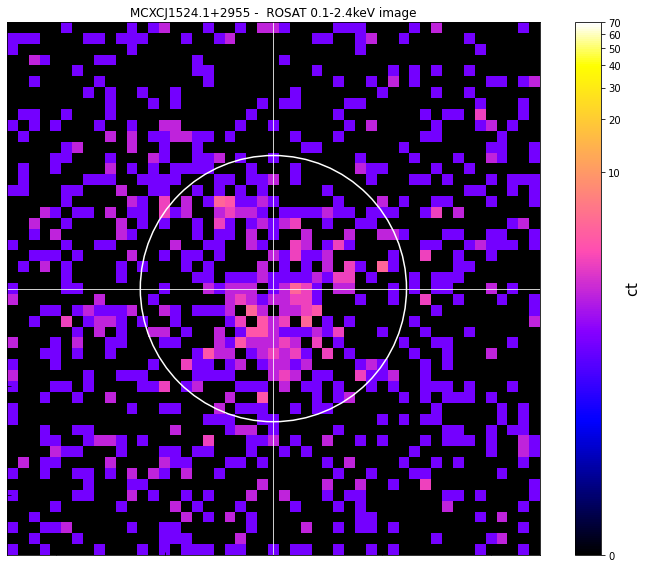

MCXCJ1539.5-8335


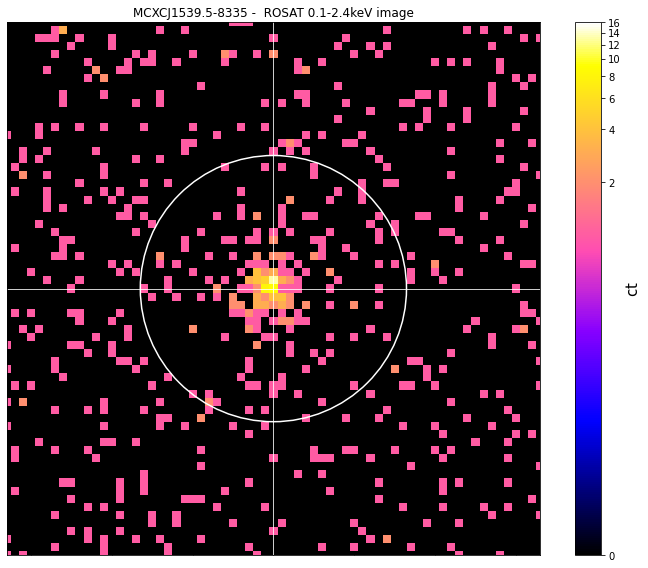

MCXCJ1558.3+2713


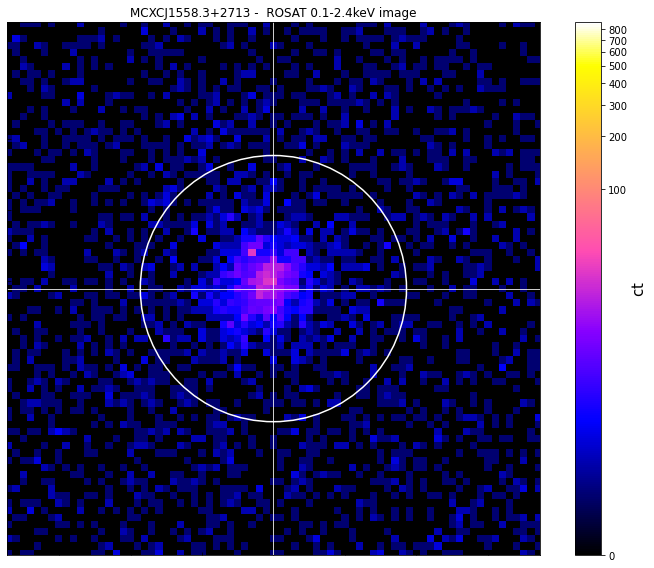

MCXCJ1558.3-1410


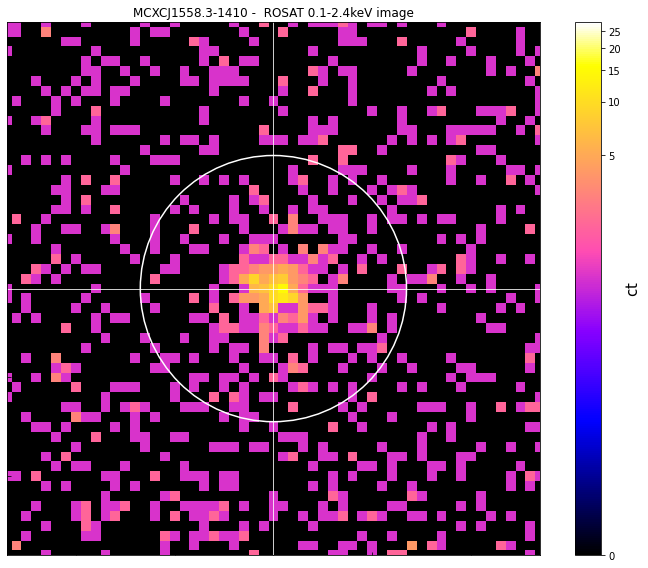

MCXCJ1602.3+1601


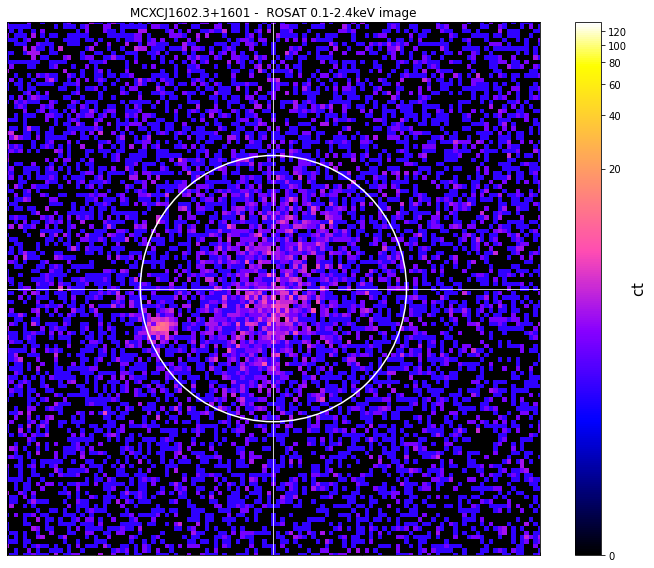

MCXCJ1620.5+2953


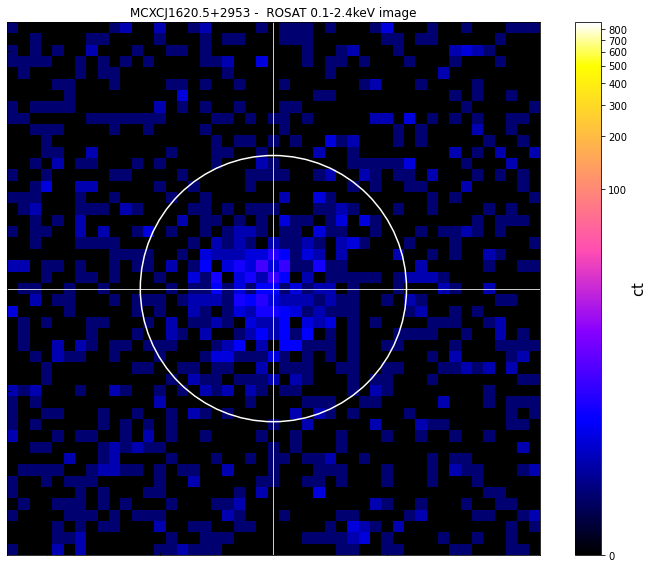

MCXCJ1628.6+3932


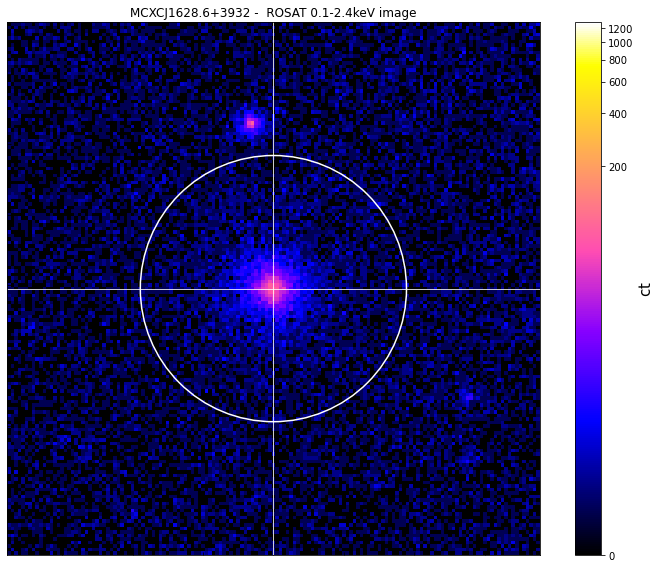

MCXCJ1659.7+3236


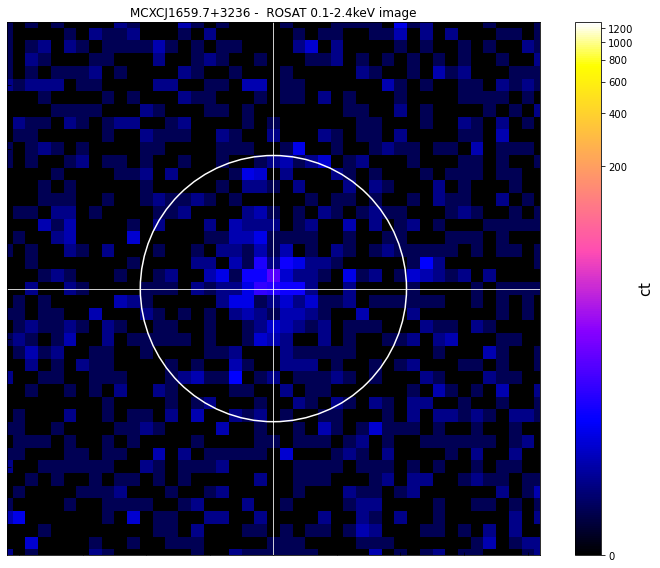

MCXCJ1702.7+3403


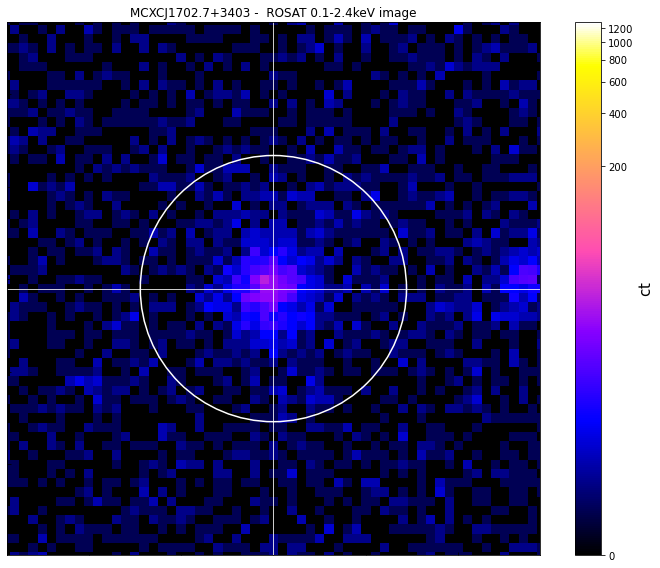

MCXCJ1703.8+7838


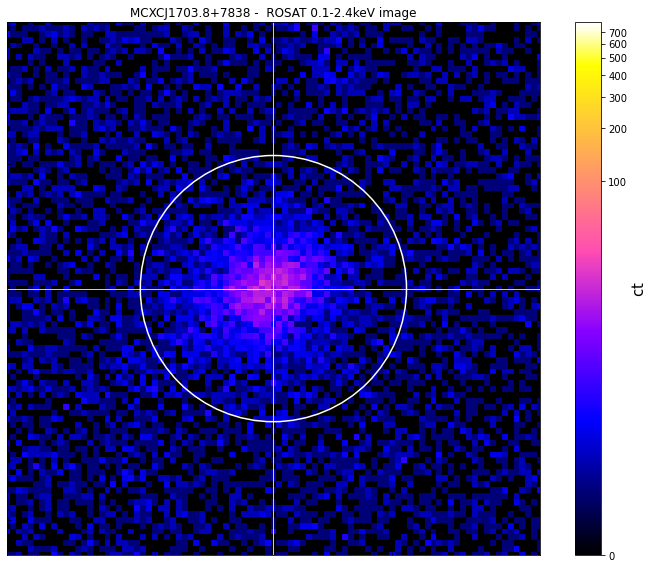

MCXCJ1709.8+3426


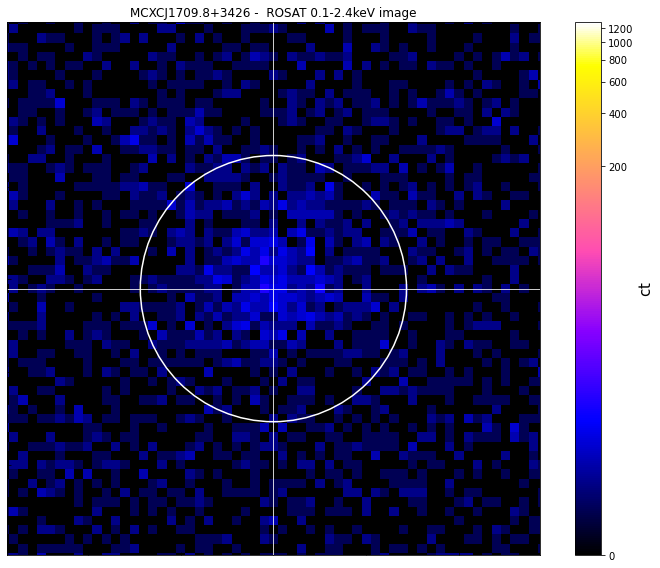

MCXCJ1712.7+6403


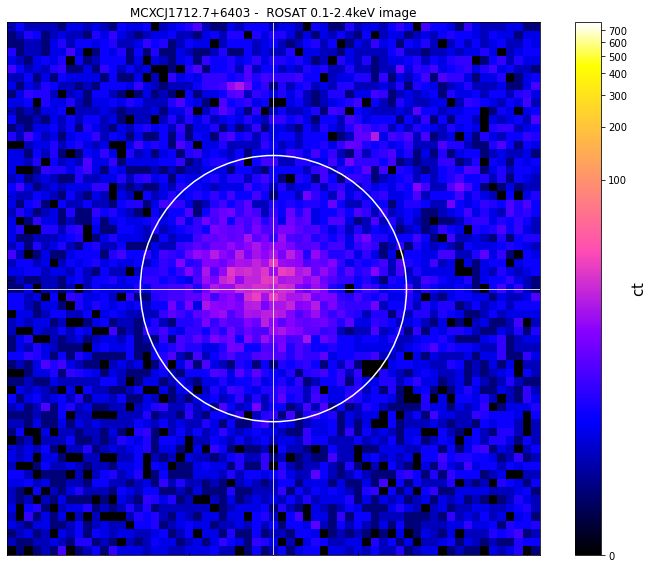

MCXCJ2034.7-3548


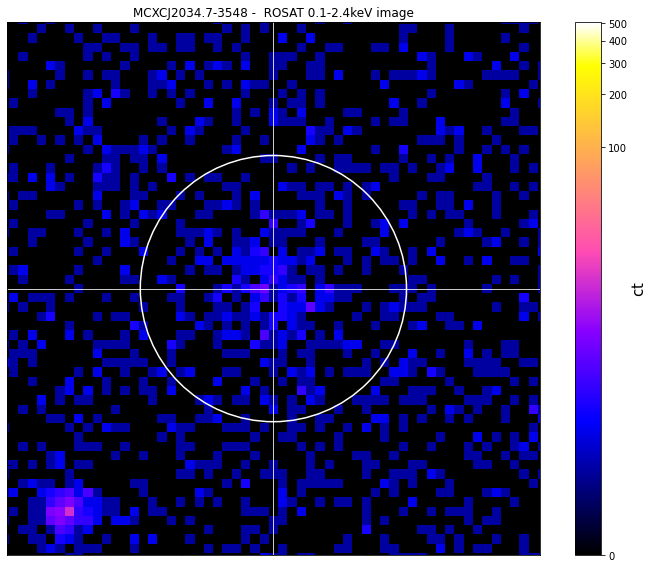

MCXCJ2134.2-1328


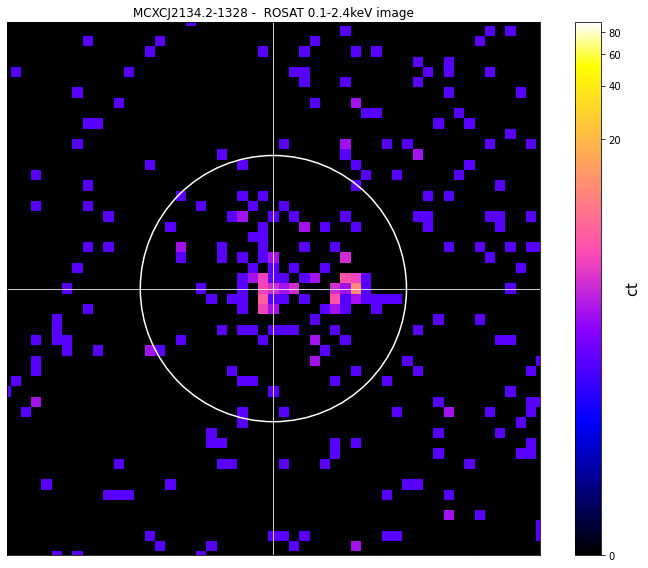

MCXCJ2143.9-5637


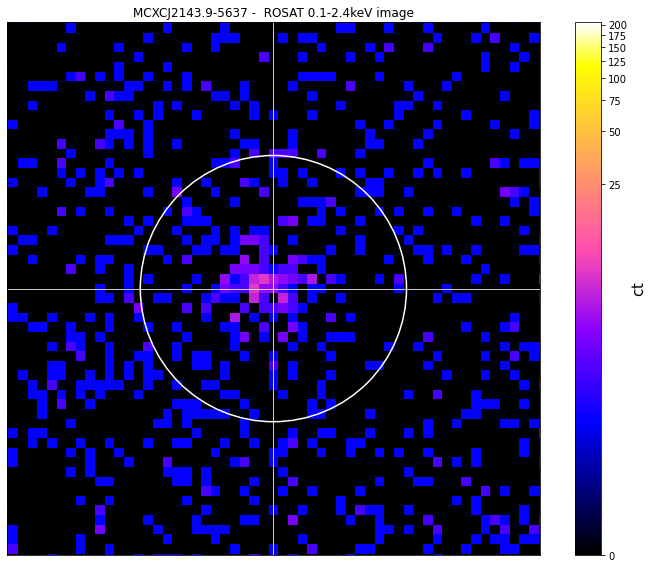

MCXCJ2145.9-1006


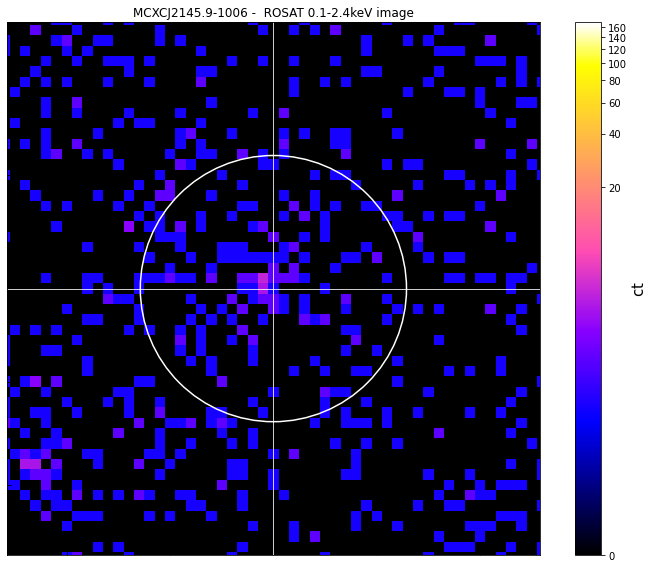

MCXCJ2149.1-3041


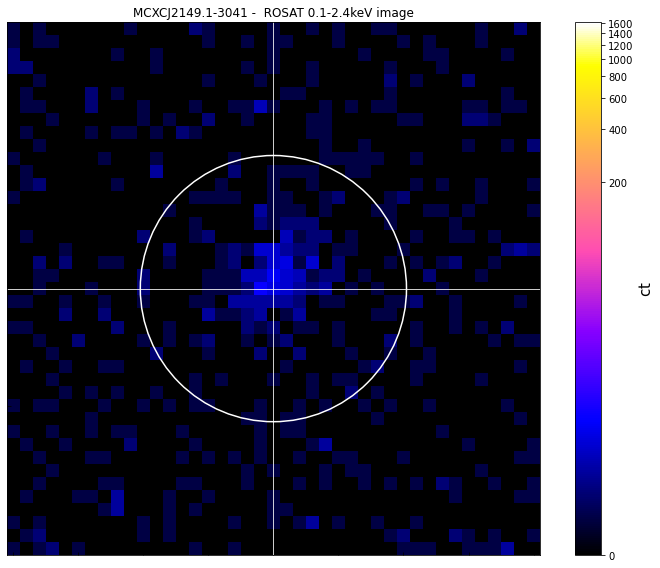

MCXCJ2152.4-1933


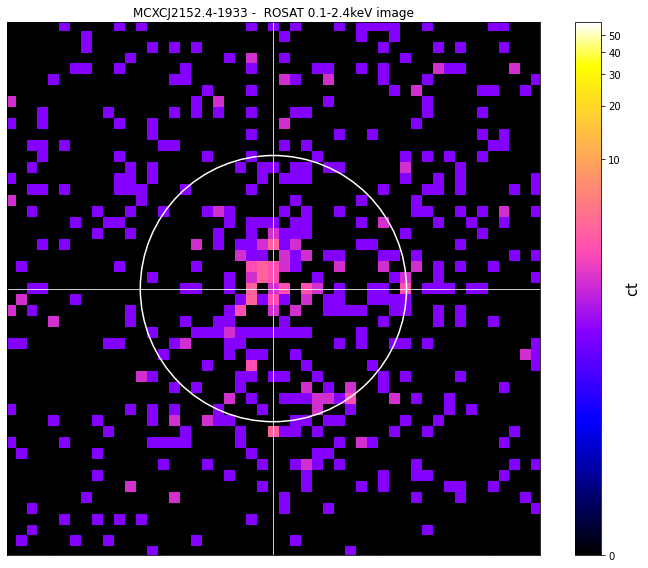

MCXCJ2154.1-5751


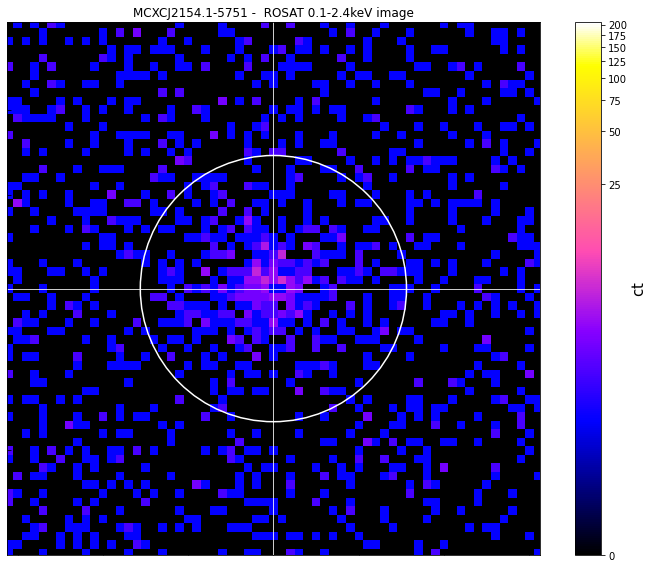

MCXCJ2158.4-6023


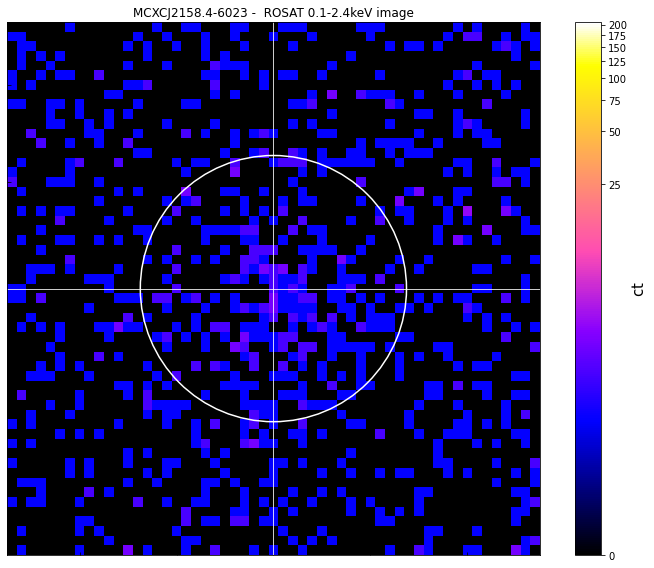

MCXCJ2201.9-5956


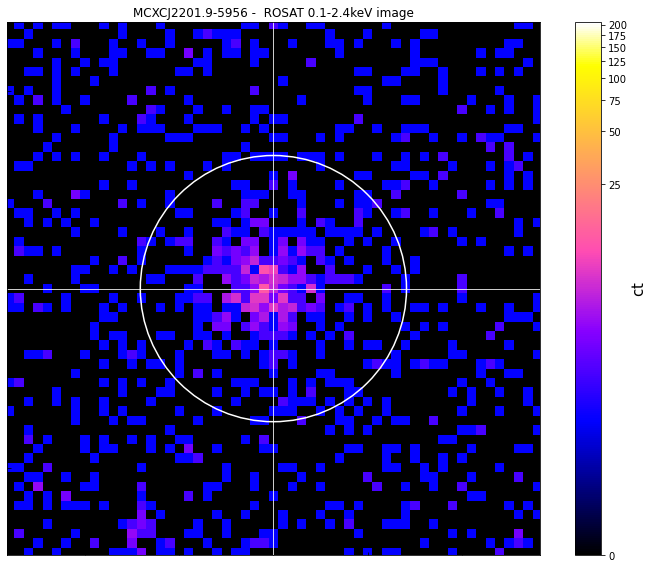

MCXCJ2205.6-0535


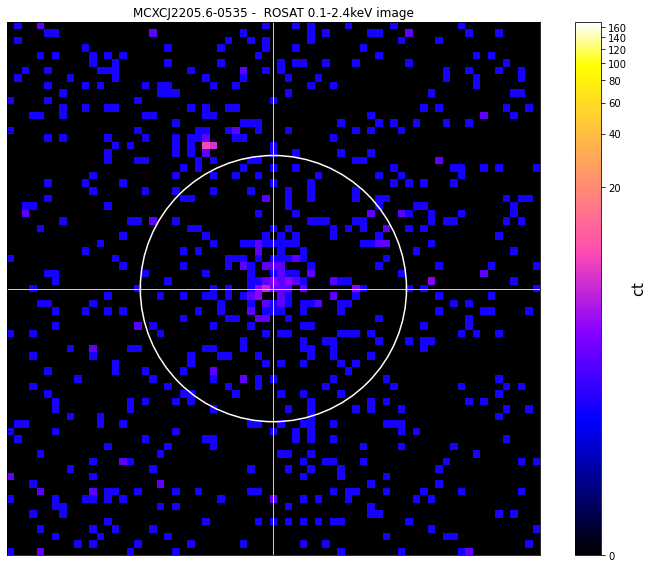

MCXCJ2209.3-5148


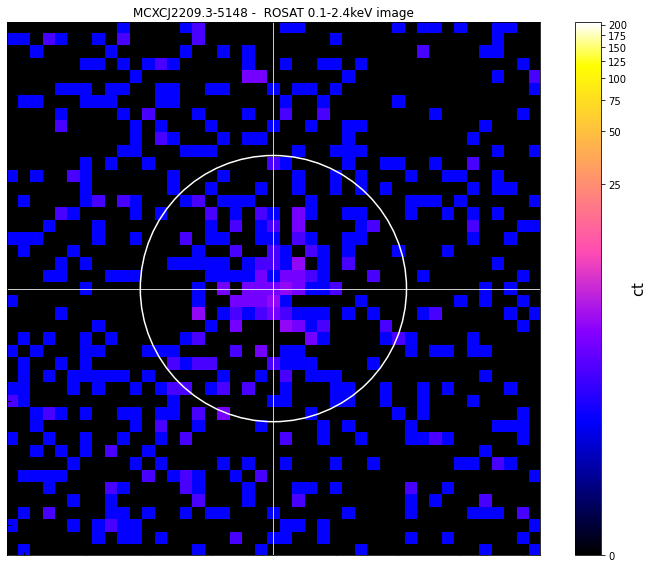

MCXCJ2210.3-1210


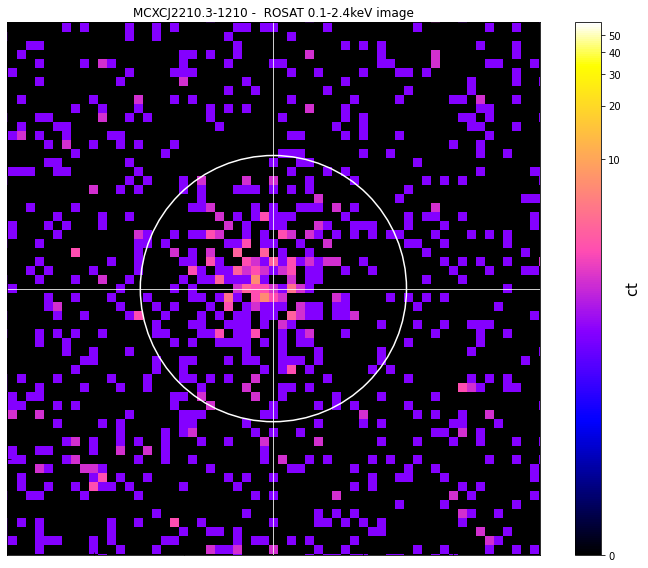

MCXCJ2214.5-1022


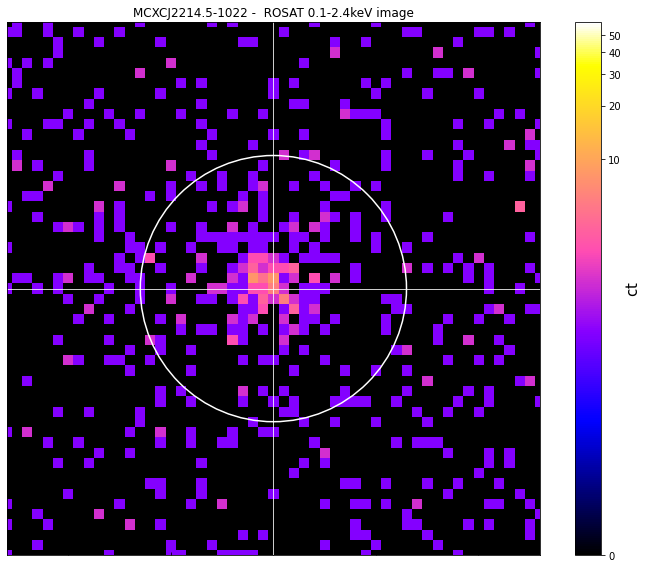

MCXCJ2216.2-0920


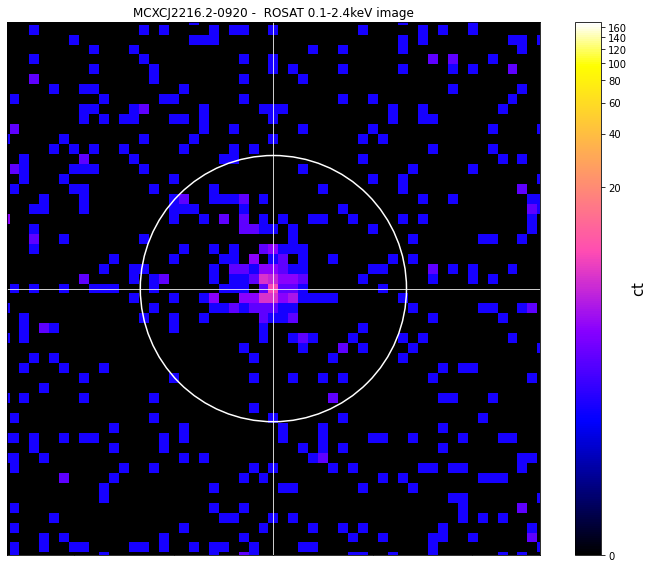

MCXCJ2218.0-6511


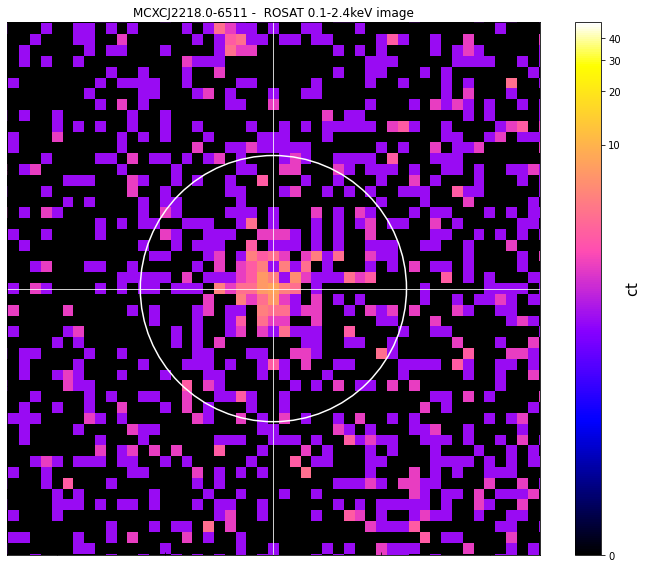

MCXCJ2218.2-0350


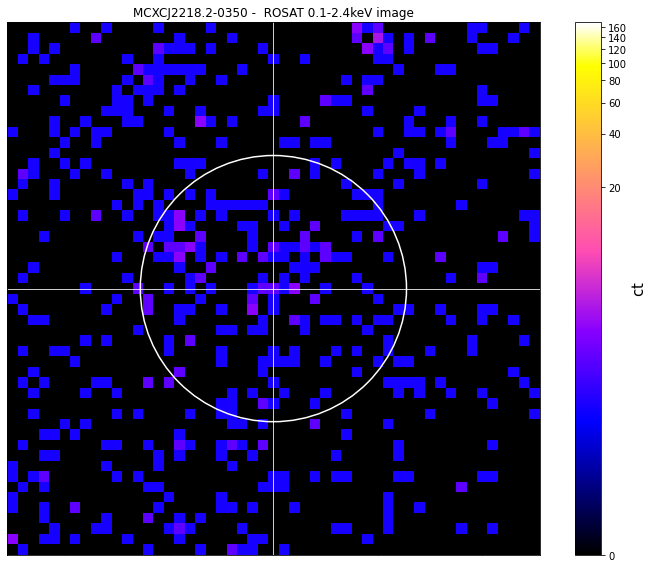

MCXCJ2223.8-0138


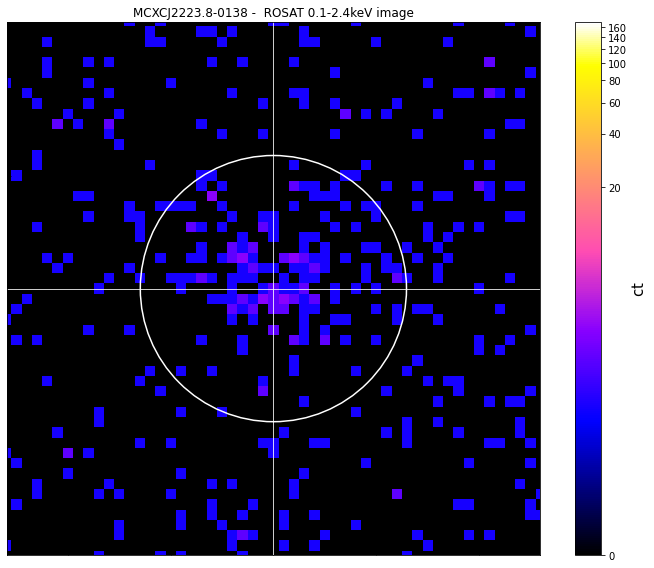

MCXCJ2226.0+1722


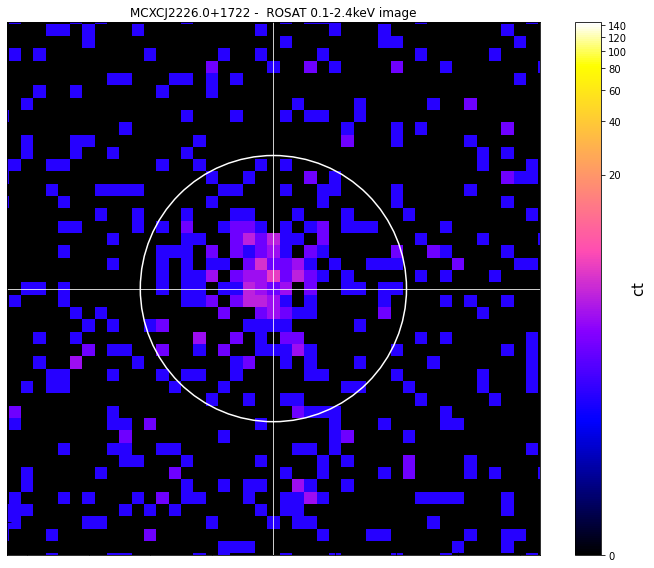

MCXCJ2246.3-5243


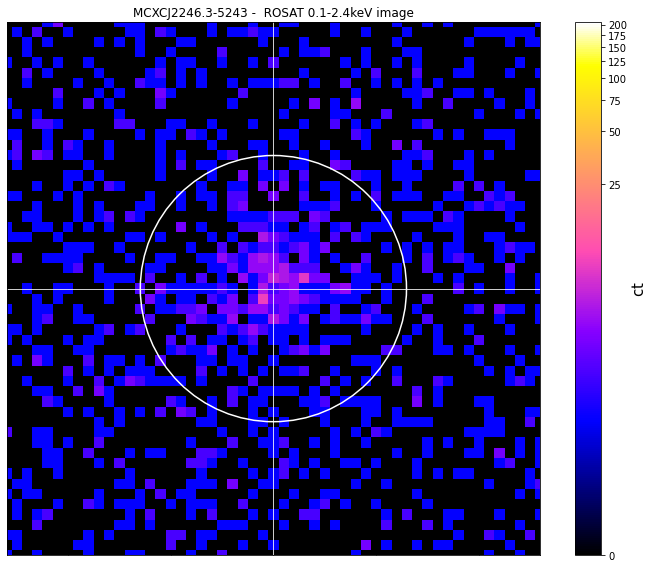

MCXCJ2249.9-6425


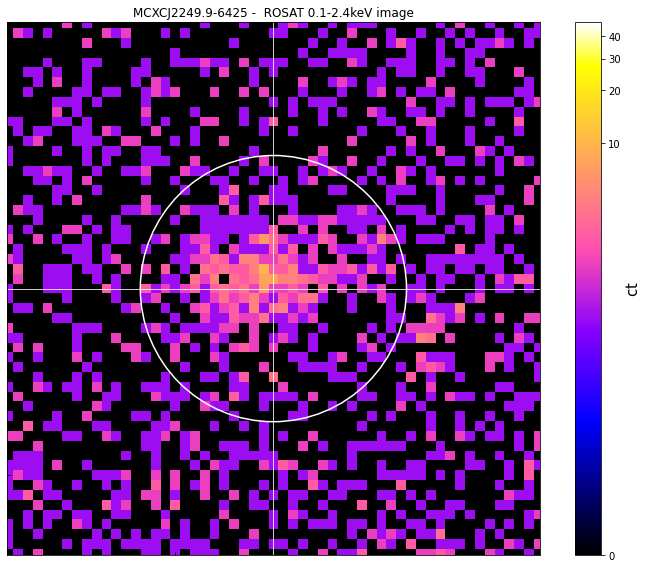

MCXCJ2307.2-1513


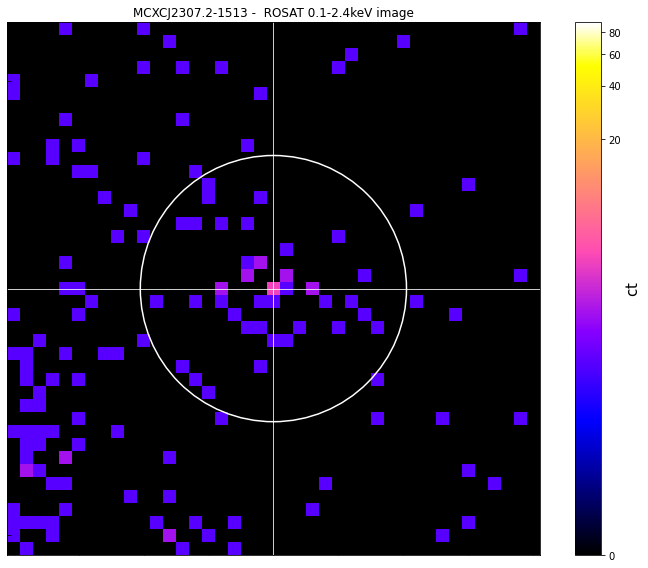

MCXCJ2312.3-2130


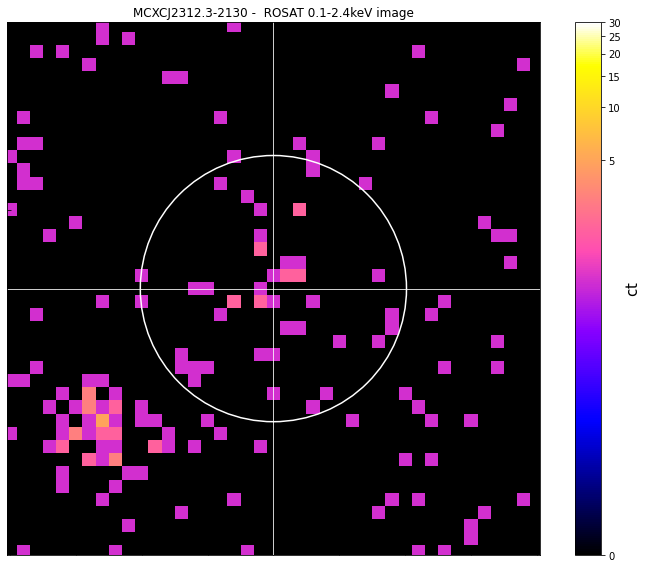

MCXCJ2313.0-2137


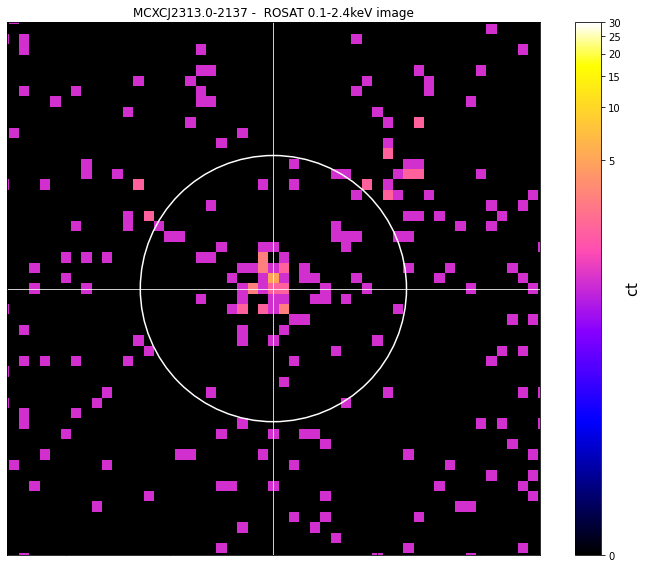

MCXCJ2313.9-4244


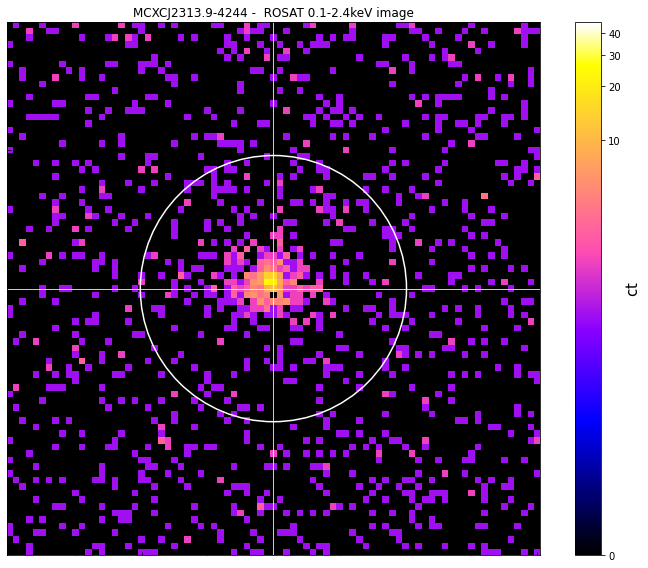

MCXCJ2316.1-2027


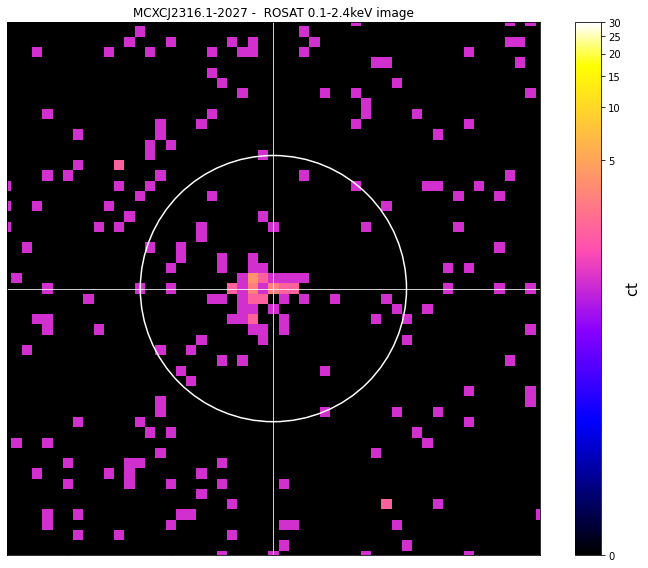

MCXCJ2319.1-4206


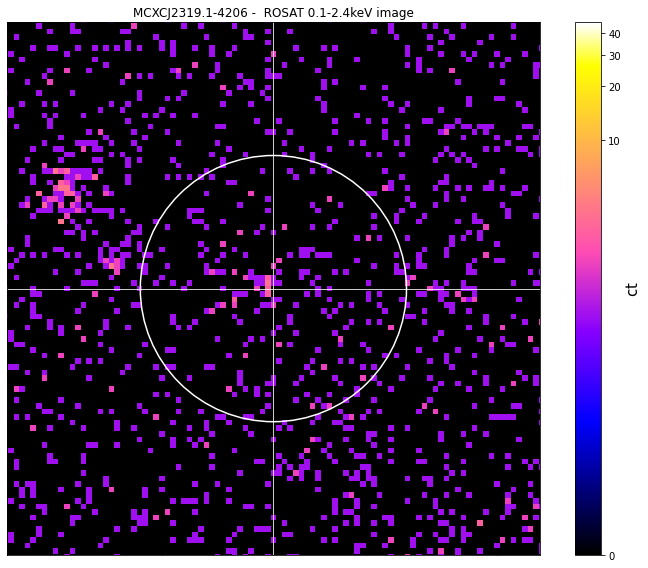

MCXCJ2321.5-4153


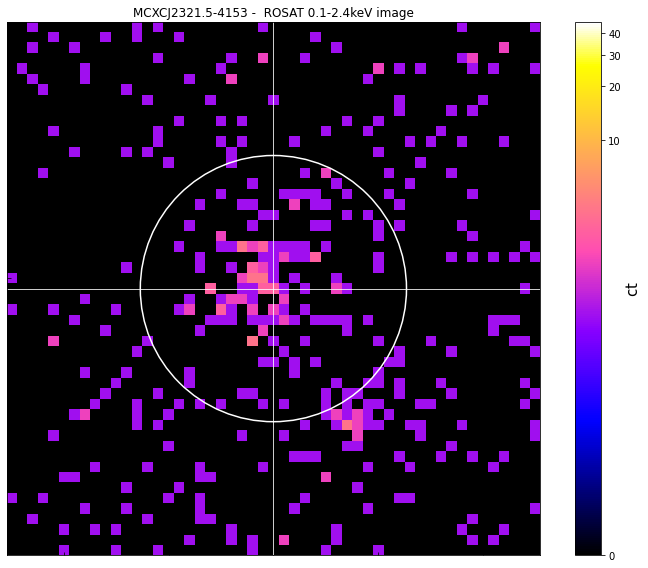

MCXCJ2323.8+1648


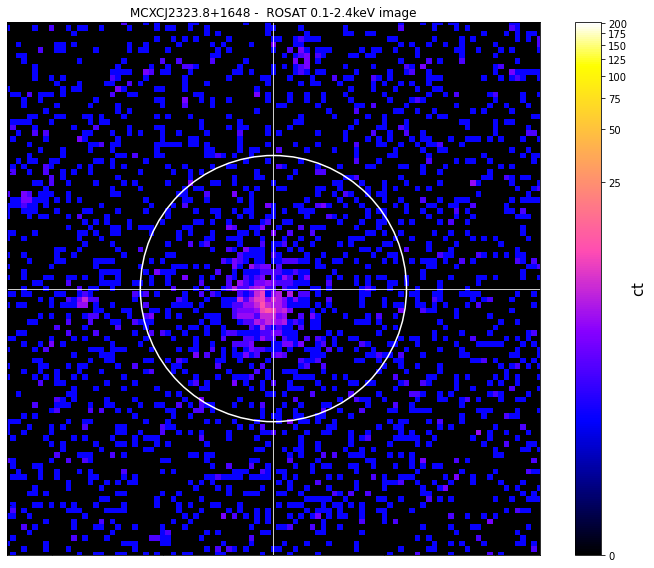

MCXCJ2325.3-1207


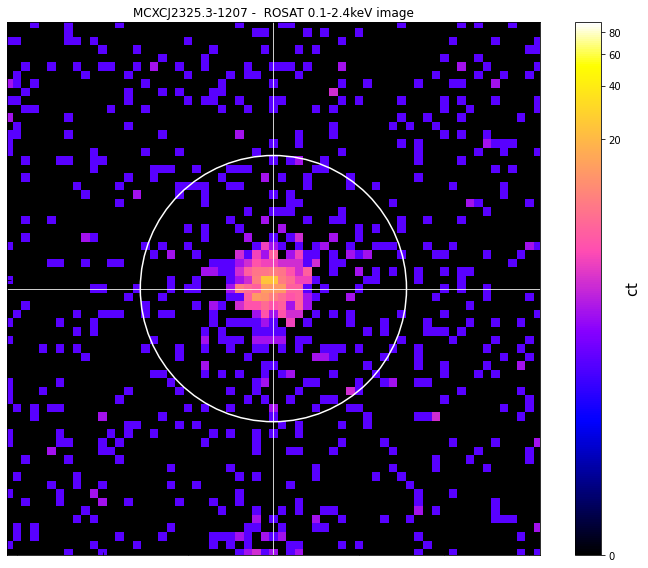

MCXCJ2331.2-3630


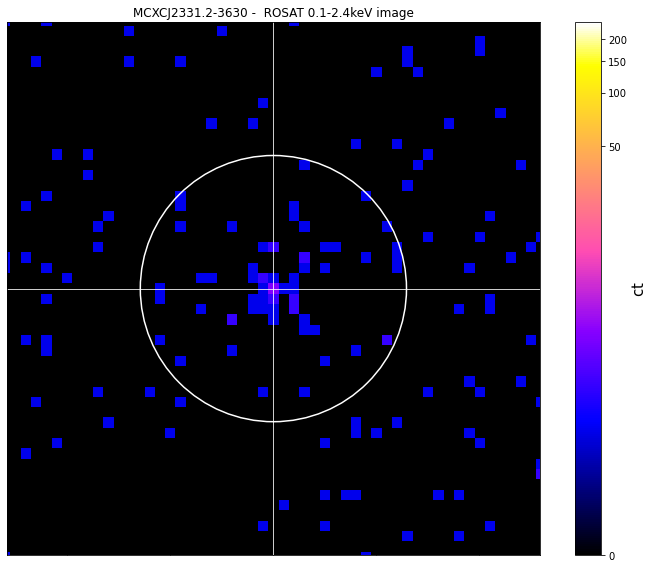

MCXCJ2344.2-0422


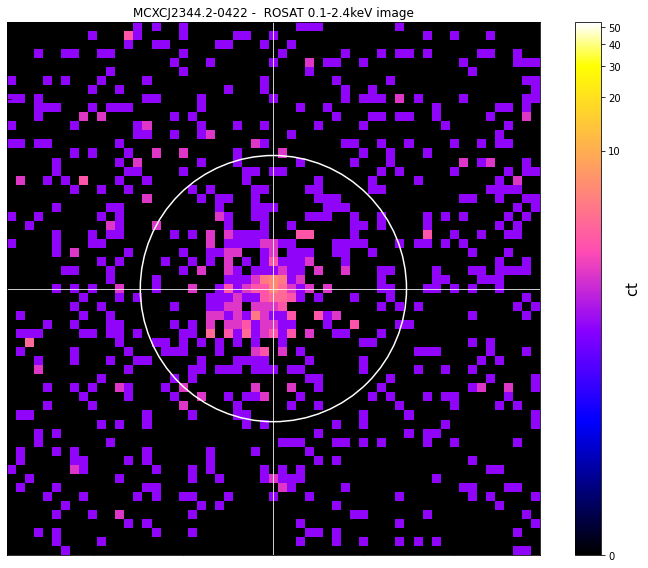

MCXCJ2347.7-2808


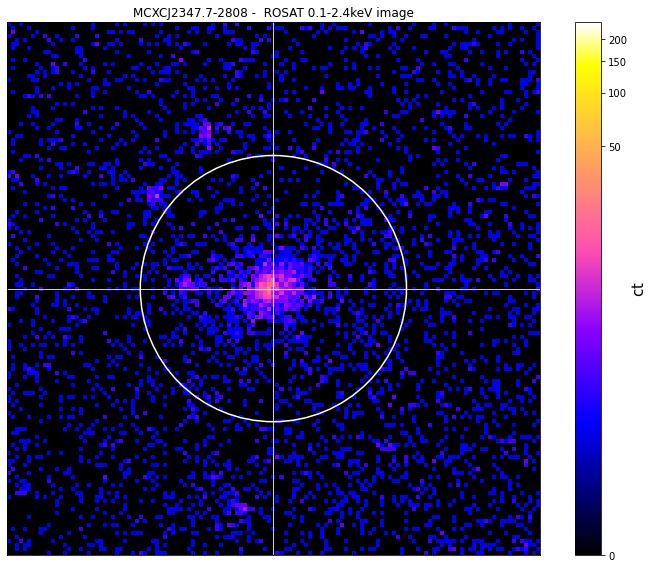

MCXCJ2354.2-1024


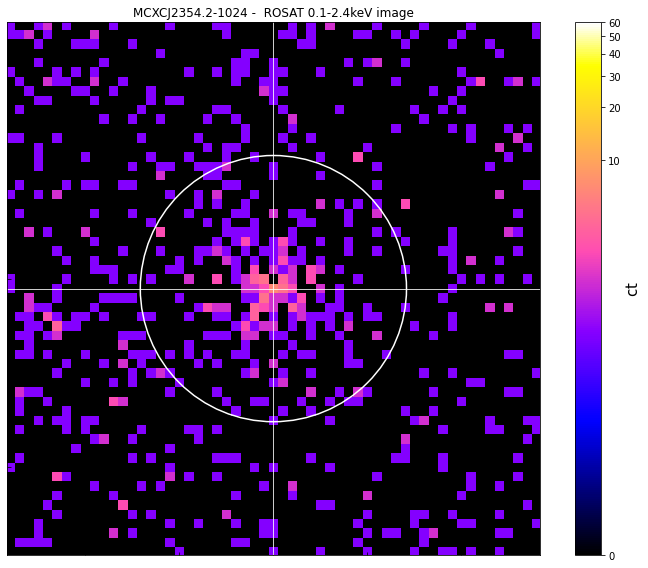

MCXCJ2357.0-3445


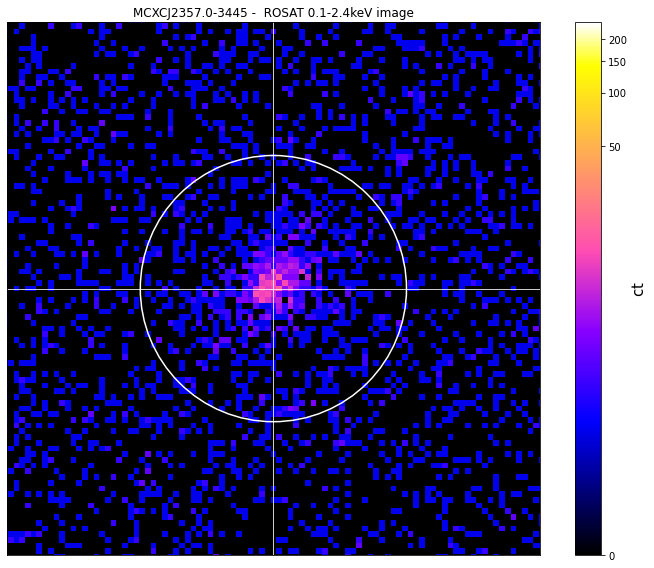

MCXCJ2359.3-6042


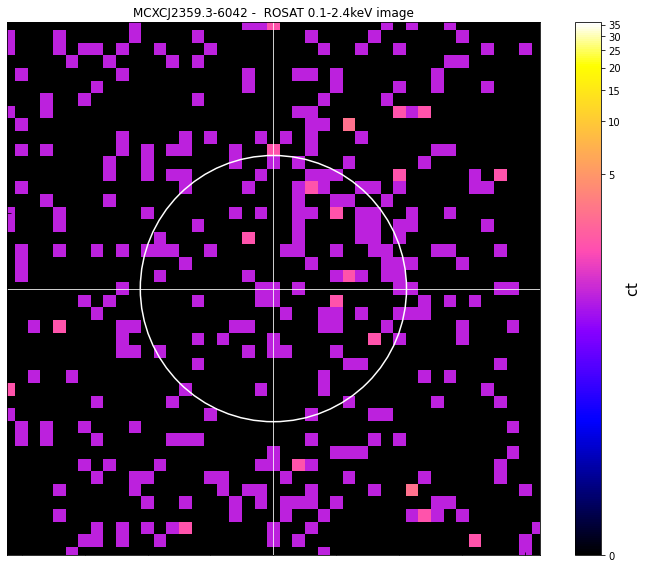

In [10]:
view_subsamp(obs_samp)